In [1]:
!pip install transformers==4.43.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import io
from transformers import AutoModelForAudioClassification, Wav2Vec2FeatureExtractor

In [ ]:
num_classes = 7

model_name = 'amiriparian/ExHuBERT'

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

model = AutoModelForAudioClassification.from_pretrained(
    model_name,
    trust_remote_code=True,
    revision="b158d45ed8578432468f3ab8d46cbe5974380812"
)

model.classifier = nn.Linear(in_features=256, out_features=num_classes)

model.freeze_og_encoder()
model.freeze_feature_encoder()

model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
else:
    print("Only one GPU available, or CUDA is not enabled. Using a single device.")
model = model.to(device)

print(f"Model moved to device: {device}")
if isinstance(model, nn.DataParallel):
    print("Model is wrapped with DataParallel.")

class EmotionDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, max_length):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        emotion = torch.tensor(row['emotion'], dtype=torch.int64)

        audio_bytes = row['audio']['bytes']
        audio_buffer = io.BytesIO(audio_bytes)
        audio_data, samplerate = librosa.load(audio_buffer, sr=16000)

        audio_features = self.feature_extractor(
            audio_data,
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        audio = audio_features['input_values'].squeeze(0)
        return audio, emotion

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

ExHuBERT_model.py: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Some weights of the model checkpoint at amiriparian/ExHuBERT were not used when initializing ExHuBERT: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing ExHuBERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ExHuBERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ExHuBERT were not initialized from the model checkpoint at amiriparian/ExHuBERT and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for

Using 2 GPUs!
Model moved to device: cuda
Model is wrapped with DataParallel.


In [ ]:
import pandas as pd
import os
import glob
from tqdm import tqdm

dataset_path = "/kaggle/input/brytserc"

MAX_DATAPOINTS = None

audio_data_list = []
emotions = []
genders = []

if not os.path.exists(dataset_path):
    print(f"Error: Dataset directory not found at {dataset_path}")
else:
    print(f"Dataset directory found at {dataset_path}")

    wav_files = glob.glob(os.path.join(dataset_path, "*.wav"))

    if not wav_files:
        print(f"No .wav files found in {dataset_path}")
    else:
        print(f"Found {len(wav_files)} .wav files. Processing...")
        
        if MAX_DATAPOINTS is not None:
            wav_files = wav_files[:MAX_DATAPOINTS]
            print(f"Limiting processing to first {MAX_DATAPOINTS} files")
        
        for file_path in tqdm(wav_files, desc="Processing audio files"):
            filename = os.path.basename(file_path)
            name_without_extension = os.path.splitext(filename)[0]
            parts = name_without_extension.split('_')

            if len(parts) >= 2: 
                emotion = parts[0]
                gender = parts[2]

                try:
                    with open(file_path, 'rb') as f:
                        audio_bytes = f.read()

                    audio_data_list.append({'bytes': audio_bytes})
                    emotions.append(emotion)
                    genders.append(gender)

                except Exception as e:
                    tqdm.write(f"Error reading file {filename}: {e}. Skipping.")
            else:
                tqdm.write(f"Warning: Could not parse filename {filename} for emotion and gender. Skipping.")

        if not audio_data_list:
            print("No valid audio files were processed to create a DataFrame.")
        else:
            data = {
                'audio': audio_data_list,
                'emotion': emotions,
                'gender': genders
            }

            df = pd.DataFrame(data)
            print(f"\nSuccessfully created DataFrame with {len(df)} samples")
            
            print("\nDataFrame sample info:")
            print(df.info())
            print("\nEmotion distribution:")
            print(df['emotion'].value_counts())

Dataset directory found at /kaggle/input/brytserc
Found 5215 .wav files. Processing...


Processing audio files: 100%|██████████| 5215/5215 [00:50<00:00, 103.69it/s]



Successfully created DataFrame with 5215 samples

DataFrame sample info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5215 entries, 0 to 5214
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   audio    5215 non-null   object
 1   emotion  5215 non-null   object
 2   gender   5215 non-null   object
dtypes: object(3)
memory usage: 122.4+ KB
None

Emotion distribution:
emotion
Surprise    745
Neutral     745
Angry       745
Sad         745
Disgust     745
Happy       745
Fear        745
Name: count, dtype: int64


In [ ]:
if 'df' in locals() and not df.empty:
    unique_emotions = df['emotion'].unique()

    emotion_to_int = {emotion: i for i, emotion in enumerate(unique_emotions)}

    print(f"Emotion mapping: {emotion_to_int}")

    df['emotion'] = df['emotion'].map(emotion_to_int)
    
    emotion_mapping = {i: emotion for emotion, i in emotion_to_int.items()}
    target_names = [emotion_mapping[i] for i in sorted(emotion_mapping.keys())]

else:
    print("\nDataFrame 'df' not found or is empty. Please run the previous code block first.")
df

Emotion mapping: {'Surprise': 0, 'Neutral': 1, 'Angry': 2, 'Sad': 3, 'Disgust': 4, 'Happy': 5, 'Fear': 6}


,audio,emotion,gender
0,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,0,Male
1,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,1,Male
2,{'bytes': b'RIFF\xa8\t\x04\x00WAVEfmt \x10\x00...,1,Male
3,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,2,Male
4,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,0,Female
...,...,...,...
5210,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,3,Female
5211,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,2,Male
5212,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,6,Female
5213,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,1,Male


In [ ]:
from sklearn.model_selection import train_test_split

max_length = 3 * 16000

train_df, temp_df = train_test_split(
    df, 
    test_size=0.4, 
    random_state=42, 
    stratify=df['emotion']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['emotion']
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(df):.0%})")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df):.0%})")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df):.0%})")

train_dataset = EmotionDataset(train_df, feature_extractor, max_length=max_length)
val_dataset = EmotionDataset(val_df, feature_extractor, max_length=max_length)
test_dataset = EmotionDataset(test_df, feature_extractor, max_length=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


train_df

Total samples: 5215
Training samples: 3129 (60%)
Validation samples: 1043 (20%)
Test samples: 1043 (20%)


,audio,emotion,gender
3179,{'bytes': b'RIFF\xb6\t\x04\x00WAVEfmt \x10\x00...,2,Male
1491,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,6,Male
535,{'bytes': b'RIFF\xac\t\x04\x00WAVEfmt \x10\x00...,4,Male
131,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,6,Female
2876,{'bytes': b'RIFF\xb2\t\x04\x00WAVEfmt \x10\x00...,2,Male
...,...,...,...
4146,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,2,Male
2948,{'bytes': b'RIFF\xda\t\x04\x00WAVEfmt \x10\x00...,6,Male
4716,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,4,Female
3578,{'bytes': b'RIFF\xbc\t\x04\x00WAVEfmt \x10\x00...,4,Female


In [7]:
criterion = nn.CrossEntropyLoss()
lr = 1e-5
non_frozen_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(non_frozen_parameters, lr=lr, betas=(0.9, 0.999), eps=1e-08)

def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    return correct / targets.size(0)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

Train Epoch 1/20:   0%|          | 0/783 [00:00<?, ?it/s]2025-10-31 08:59:37.505507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761901177.960312      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761901178.070721      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Val Epoch 1/20: 100%|██████████| 261/261 [01:49<00:00,  2.38it/s]



Epoch [1/20]
Train Loss: 1.0064 | Train Acc: 0.6590
Val Loss: 1.0057 | Val Acc: 0.6654

Running evaluation on Test Set...


Test Epoch 1/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 1
              precision    recall  f1-score   support

    Surprise     0.8400    0.7047    0.7664       149
     Neutral     0.6923    0.5436    0.6090       149
       Angry     0.9737    0.2483    0.3957       149
         Sad     0.7667    0.7718    0.7692       149
     Disgust     0.4507    0.8591    0.5912       149
       Happy     0.6856    0.8926    0.7755       149
        Fear     0.6370    0.5772    0.6056       149

    accuracy                         0.6568      1043
   macro avg     0.7209    0.6568    0.6447      1043
weighted avg     0.7209    0.6568    0.6447      1043



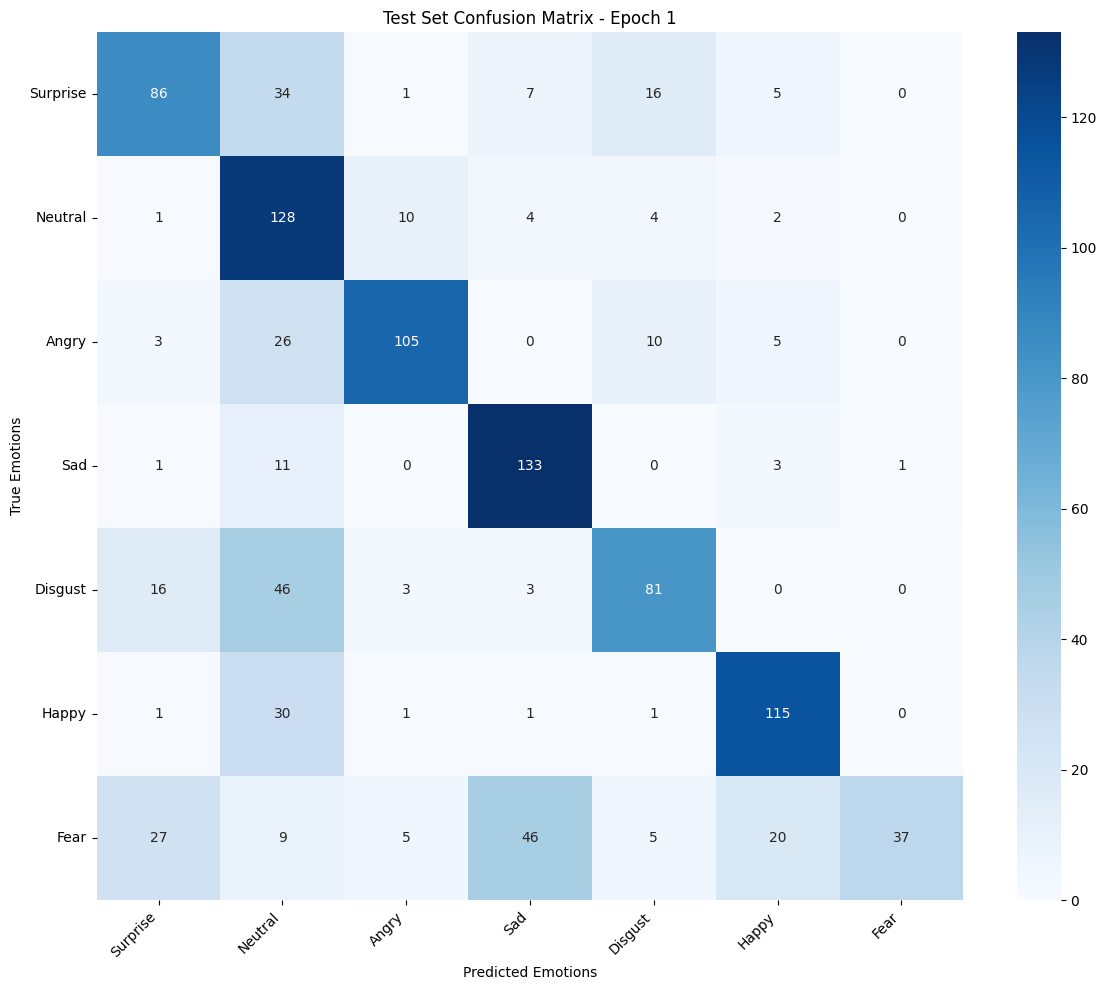

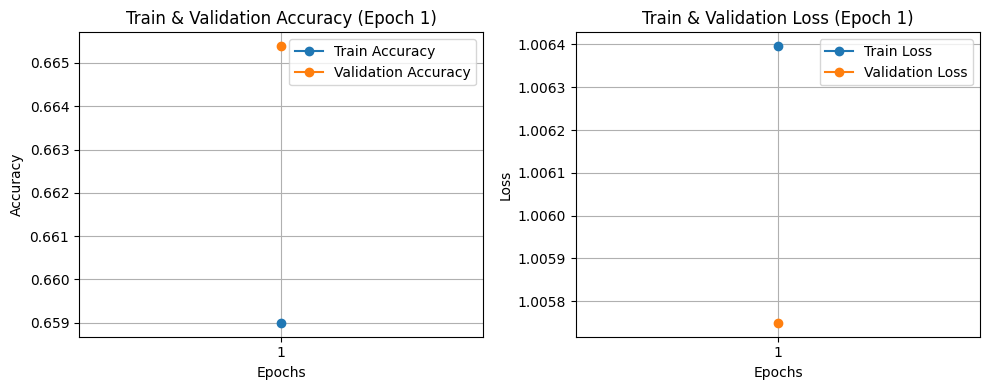


--- End of Epoch 1 ---



Val Epoch 2/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [2/20]
Train Loss: 0.5657 | Train Acc: 0.8137
Val Loss: 0.6814 | Val Acc: 0.7737

Running evaluation on Test Set...


Test Epoch 2/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 2
              precision    recall  f1-score   support

    Surprise     0.8603    0.7852    0.8211       149
     Neutral     0.5852    0.8993    0.7090       149
       Angry     0.8776    0.5772    0.6964       149
         Sad     0.9286    0.8725    0.8997       149
     Disgust     0.7413    0.7114    0.7260       149
       Happy     0.8984    0.7718    0.8303       149
        Fear     0.6627    0.7517    0.7044       149

    accuracy                         0.7670      1043
   macro avg     0.7934    0.7670    0.7695      1043
weighted avg     0.7934    0.7670    0.7695      1043



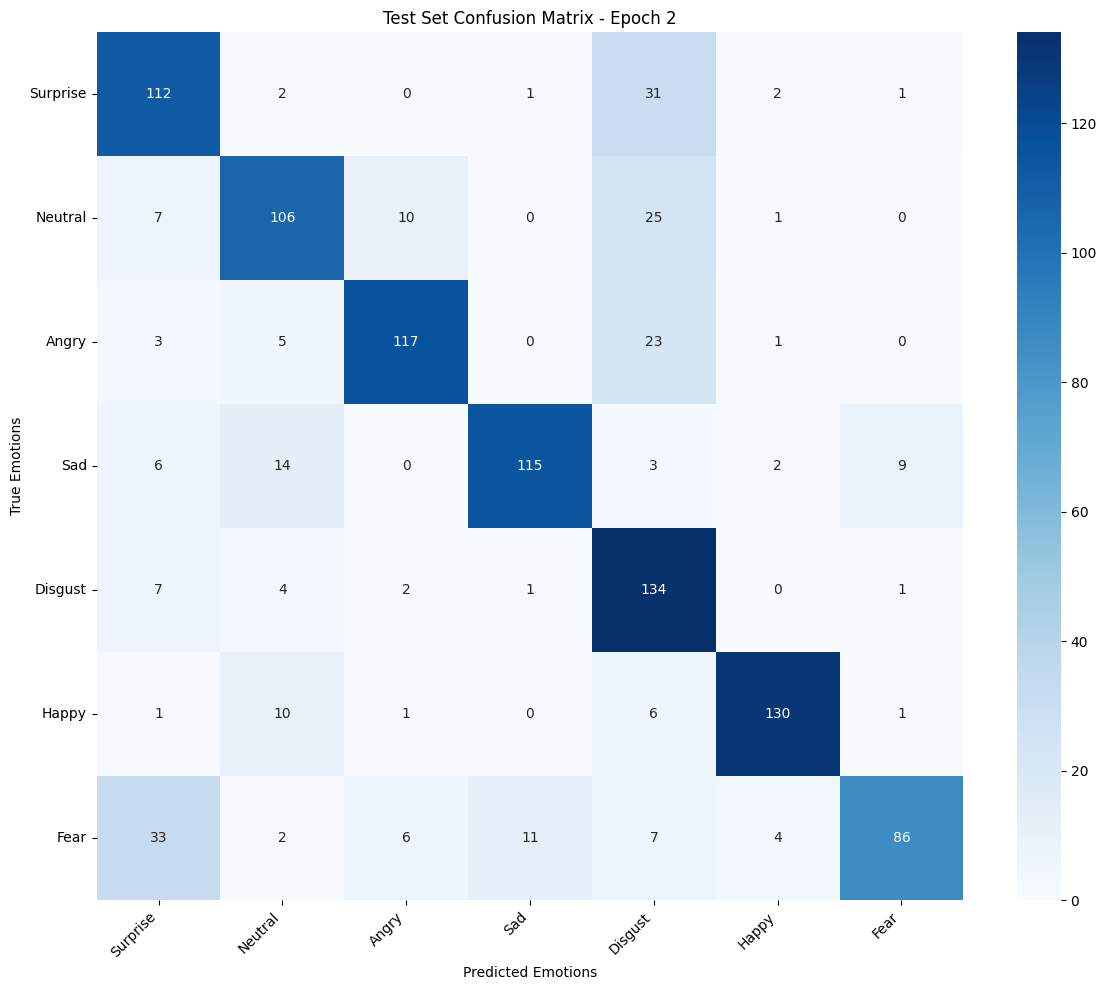

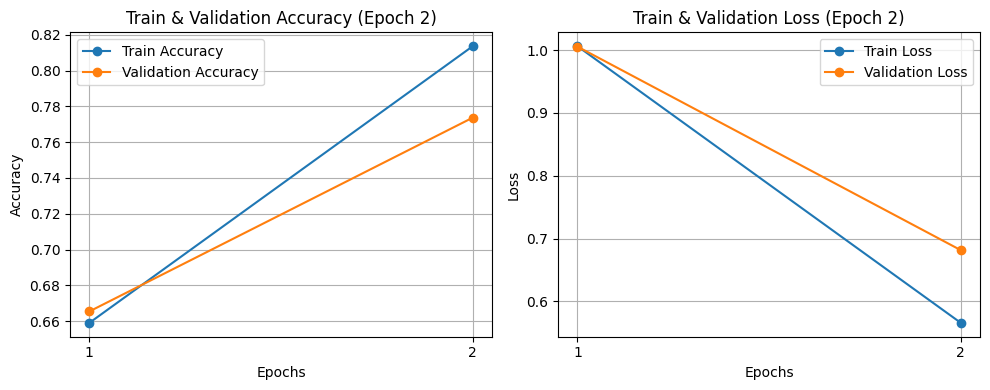


--- End of Epoch 2 ---



Val Epoch 3/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [3/20]
Train Loss: 0.3826 | Train Acc: 0.8798
Val Loss: 0.6411 | Val Acc: 0.7852

Running evaluation on Test Set...


Test Epoch 3/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 3
              precision    recall  f1-score   support

    Surprise     0.7962    0.8389    0.8170       149
     Neutral     0.7034    0.6846    0.6939       149
       Angry     0.8738    0.6040    0.7143       149
         Sad     0.8839    0.9195    0.9013       149
     Disgust     0.8271    0.7383    0.7801       149
       Happy     0.7600    0.8926    0.8210       149
        Fear     0.6800    0.7987    0.7346       149

    accuracy                         0.7824      1043
   macro avg     0.7892    0.7824    0.7803      1043
weighted avg     0.7892    0.7824    0.7803      1043



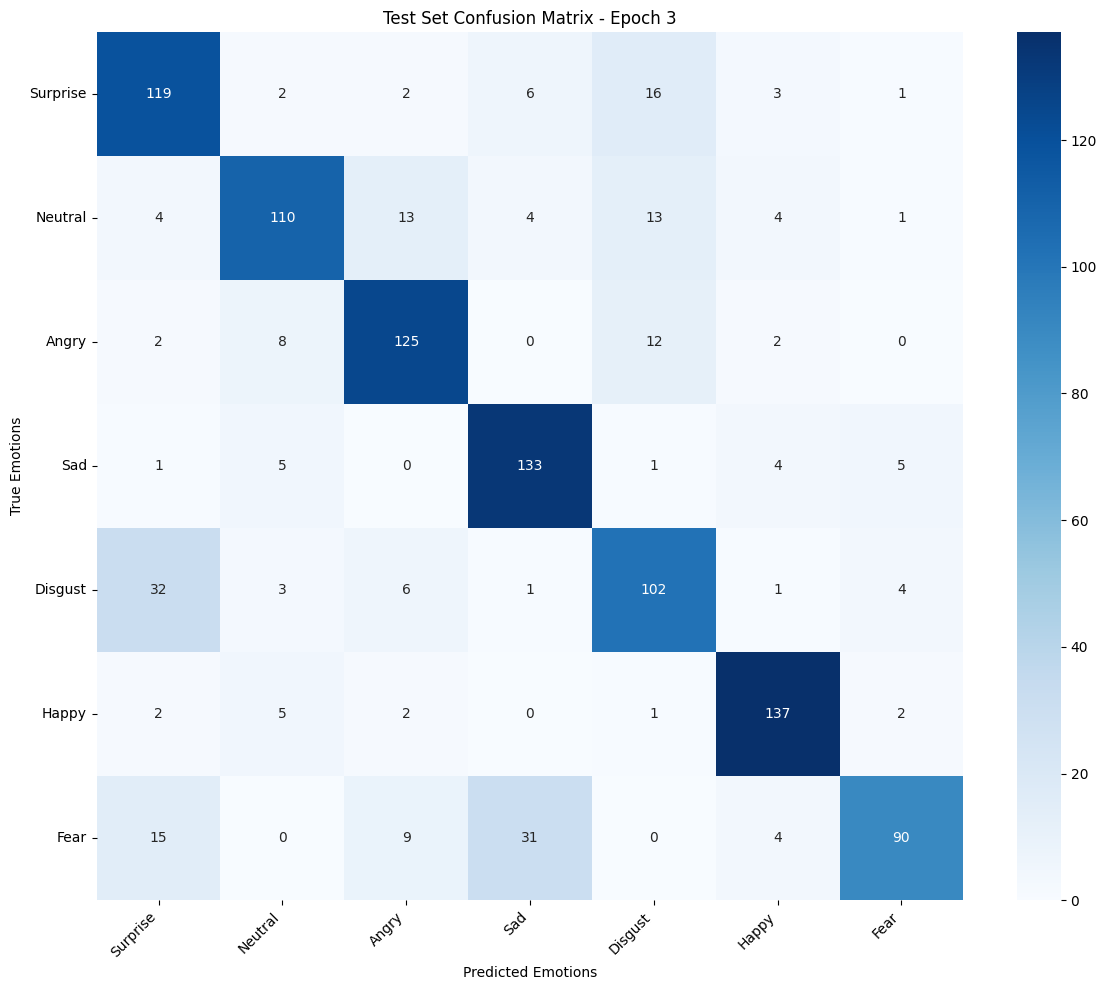

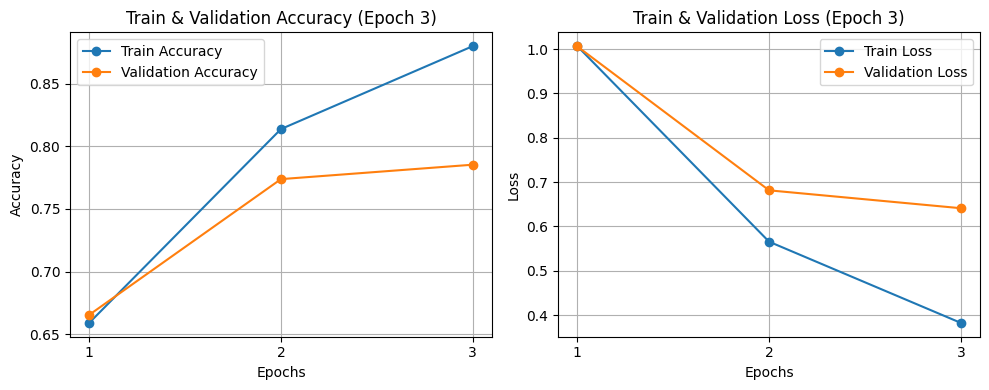


--- End of Epoch 3 ---



Val Epoch 4/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [4/20]
Train Loss: 0.2690 | Train Acc: 0.9182
Val Loss: 0.6783 | Val Acc: 0.8006

Running evaluation on Test Set...


Test Epoch 4/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 4
              precision    recall  f1-score   support

    Surprise     0.8794    0.8322    0.8552       149
     Neutral     0.7329    0.7919    0.7613       149
       Angry     0.8889    0.6980    0.7820       149
         Sad     0.8750    0.8926    0.8837       149
     Disgust     0.7595    0.8054    0.7818       149
       Happy     0.8153    0.8591    0.8366       149
        Fear     0.7325    0.7718    0.7516       149

    accuracy                         0.8073      1043
   macro avg     0.8119    0.8073    0.8074      1043
weighted avg     0.8119    0.8073    0.8074      1043



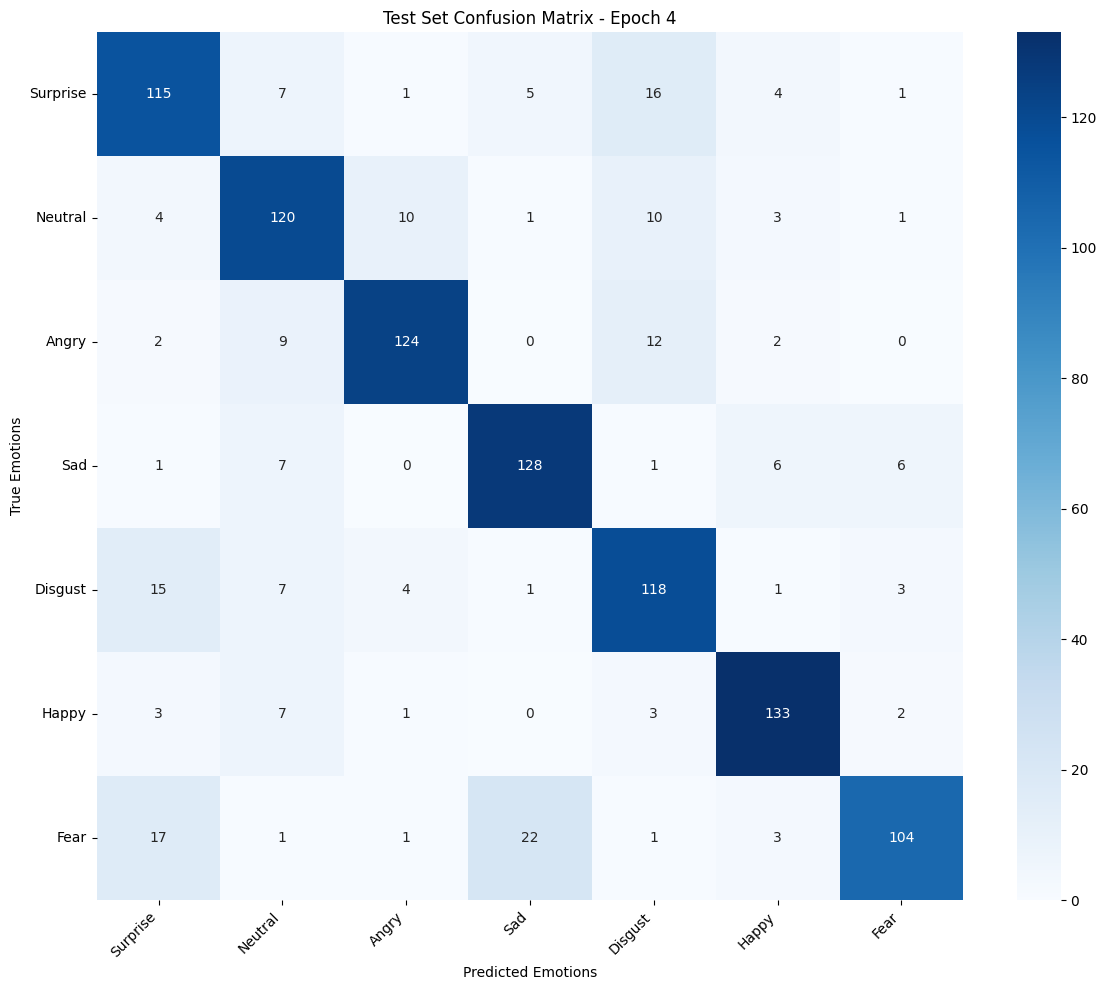

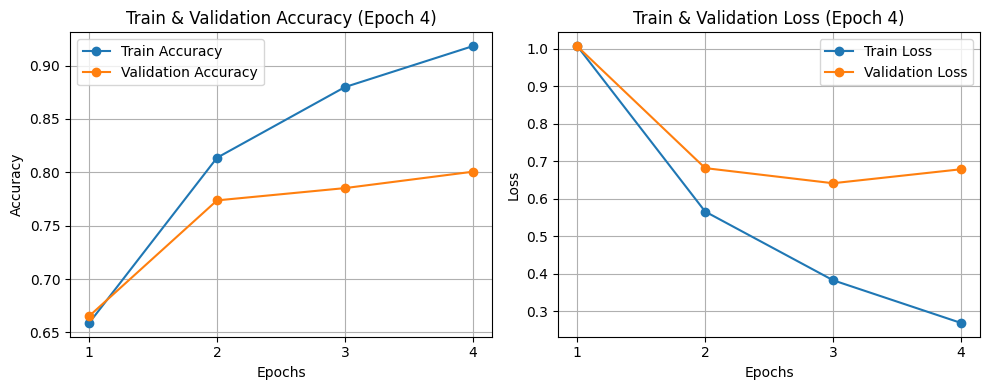


--- End of Epoch 4 ---



Val Epoch 5/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [5/20]
Train Loss: 0.2099 | Train Acc: 0.9361
Val Loss: 0.6902 | Val Acc: 0.8035

Running evaluation on Test Set...


Test Epoch 5/20: 100%|██████████| 261/261 [01:48<00:00,  2.40it/s]



Test Set Classification Report - Epoch 5
              precision    recall  f1-score   support

    Surprise     0.7627    0.9060    0.8282       149
     Neutral     0.7394    0.8188    0.7771       149
       Angry     0.9239    0.5705    0.7054       149
         Sad     0.9444    0.7987    0.8655       149
     Disgust     0.7517    0.7517    0.7517       149
       Happy     0.7875    0.8456    0.8155       149
        Fear     0.6839    0.7987    0.7368       149

    accuracy                         0.7843      1043
   macro avg     0.7991    0.7843    0.7829      1043
weighted avg     0.7991    0.7843    0.7829      1043



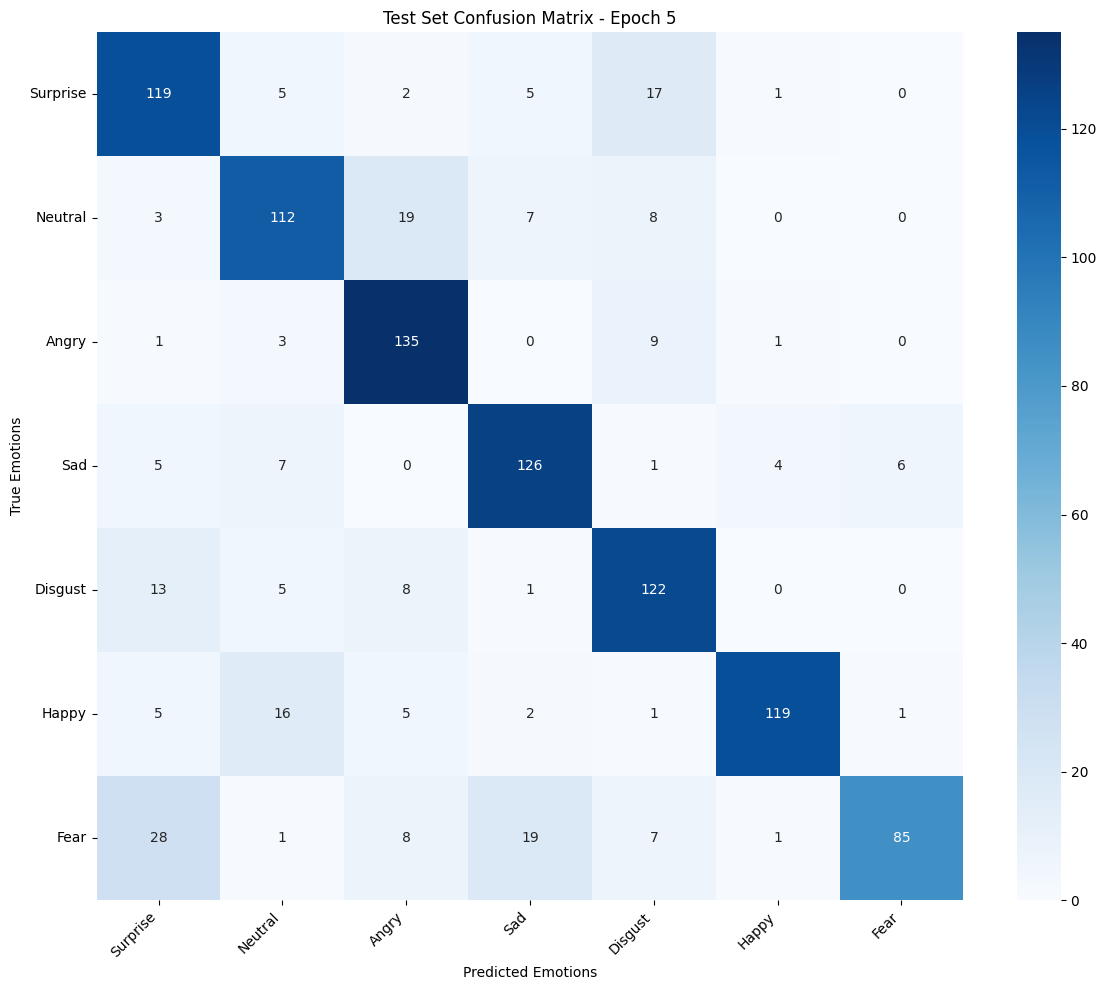

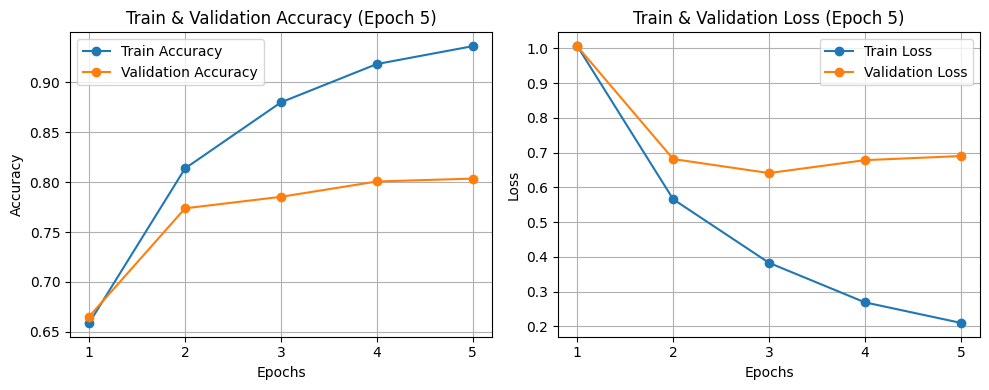


--- End of Epoch 5 ---



Val Epoch 6/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [6/20]
Train Loss: 0.1743 | Train Acc: 0.9450
Val Loss: 0.7035 | Val Acc: 0.8054

Running evaluation on Test Set...


Test Epoch 6/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 6
              precision    recall  f1-score   support

    Surprise     0.8108    0.8054    0.8081       149
     Neutral     0.7256    0.7987    0.7604       149
       Angry     0.9100    0.6107    0.7309       149
         Sad     0.8705    0.8121    0.8403       149
     Disgust     0.6231    0.8322    0.7126       149
       Happy     0.8344    0.8456    0.8400       149
        Fear     0.7324    0.6980    0.7148       149

    accuracy                         0.7718      1043
   macro avg     0.7867    0.7718    0.7724      1043
weighted avg     0.7867    0.7718    0.7724      1043



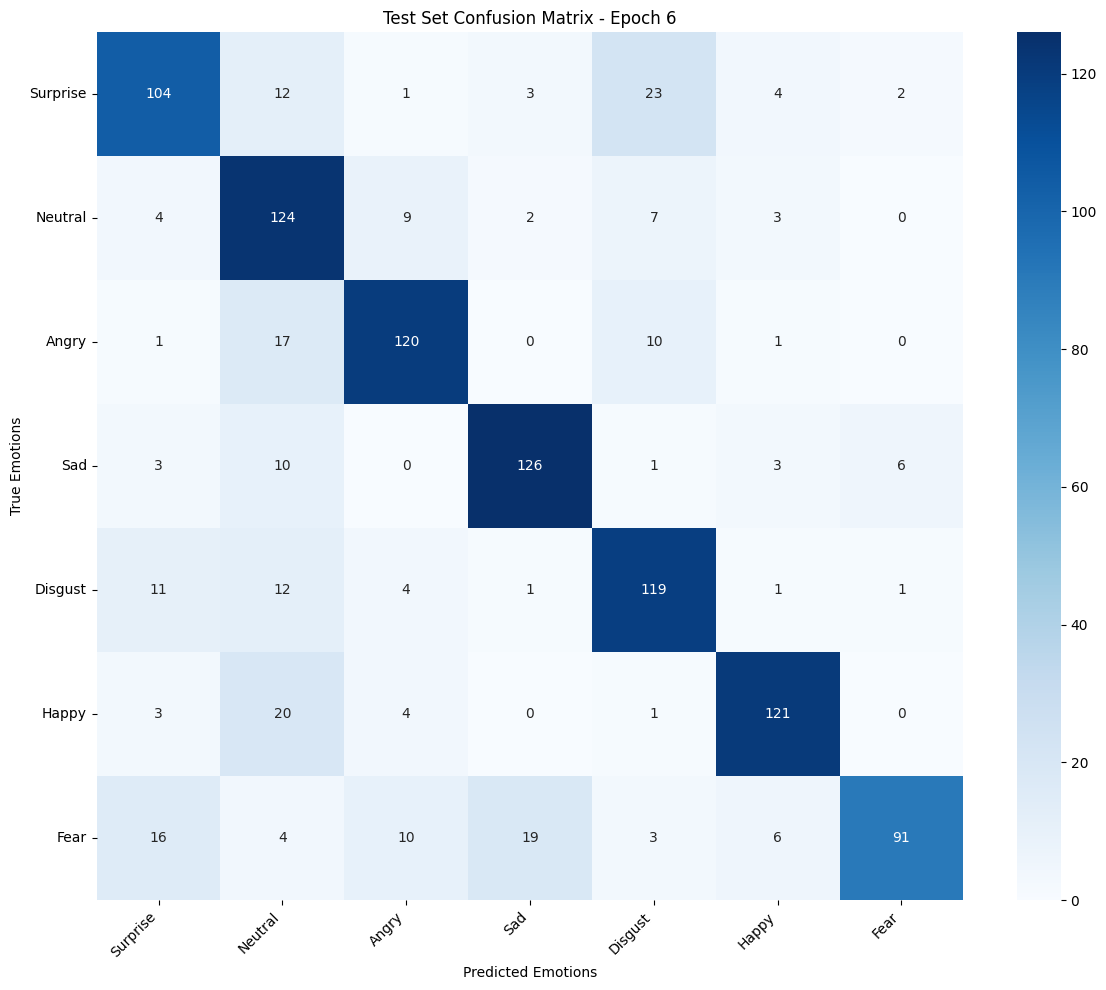

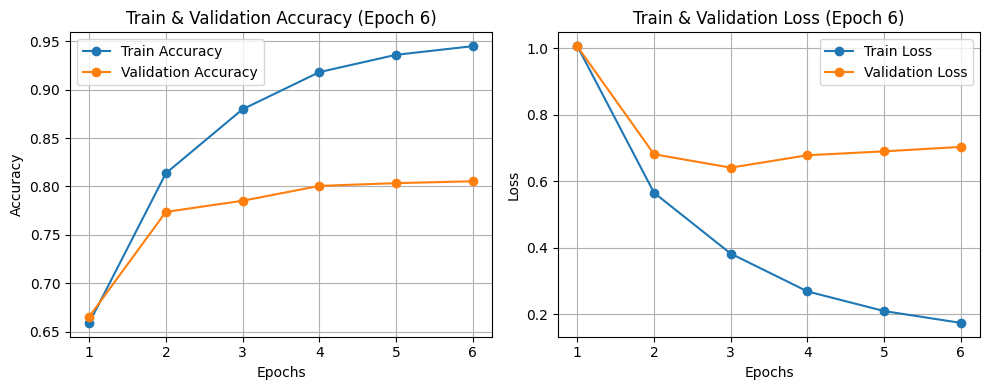


--- End of Epoch 6 ---



Val Epoch 7/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [7/20]
Train Loss: 0.1195 | Train Acc: 0.9597
Val Loss: 0.8442 | Val Acc: 0.7776

Running evaluation on Test Set...


Test Epoch 7/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 7
              precision    recall  f1-score   support

    Surprise     0.9231    0.7248    0.8120       149
     Neutral     0.6966    0.8322    0.7584       149
       Angry     0.8958    0.5772    0.7020       149
         Sad     0.9203    0.8523    0.8850       149
     Disgust     0.7566    0.7718    0.7641       149
       Happy     0.7670    0.9060    0.8308       149
        Fear     0.6613    0.8255    0.7343       149

    accuracy                         0.7843      1043
   macro avg     0.8030    0.7843    0.7838      1043
weighted avg     0.8030    0.7843    0.7838      1043



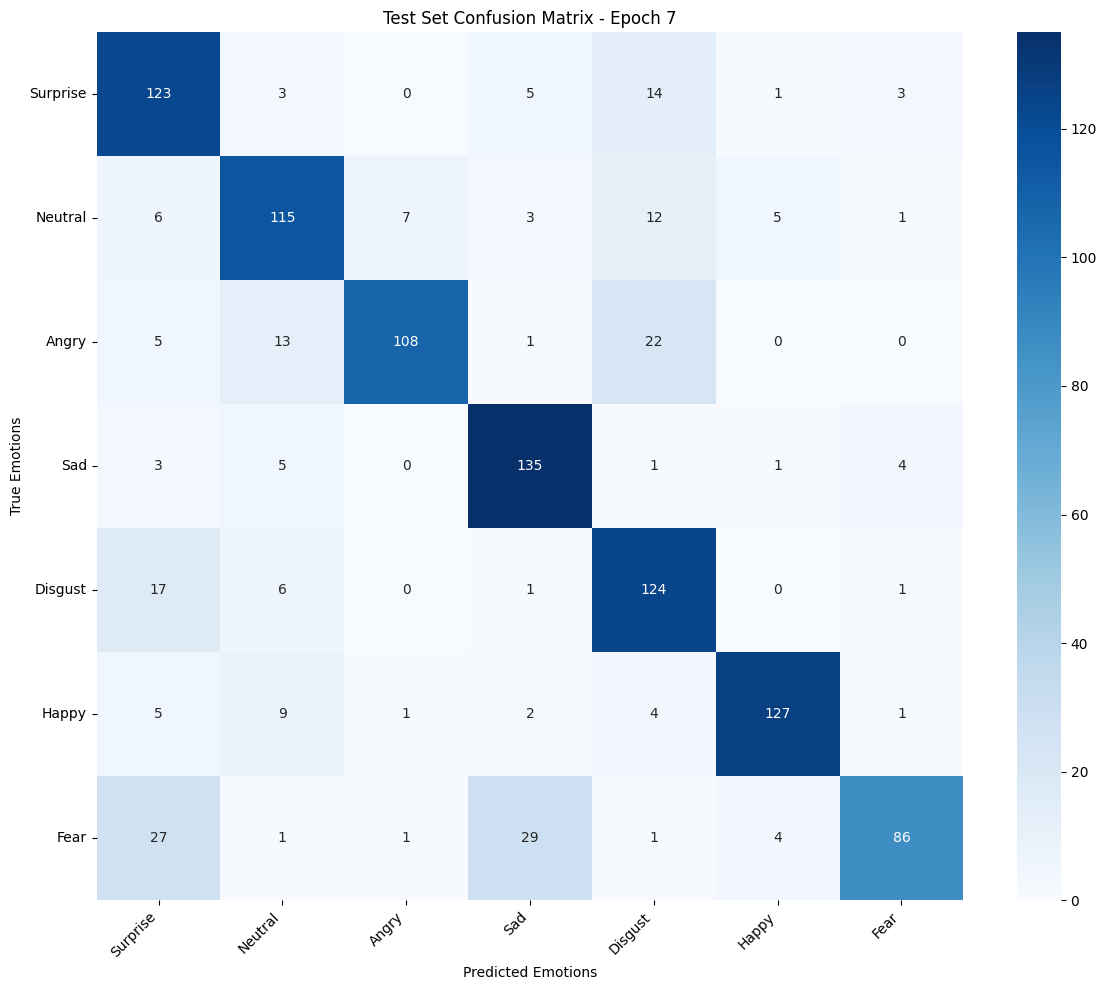

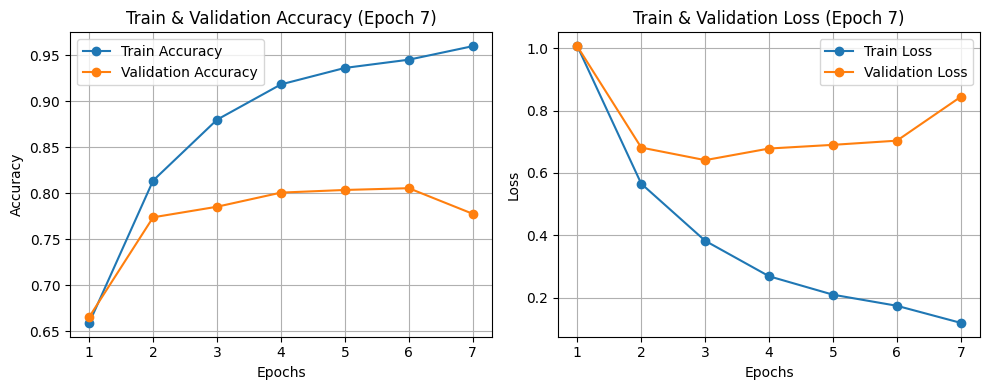


--- End of Epoch 7 ---



Val Epoch 8/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [8/20]
Train Loss: 0.1045 | Train Acc: 0.9674
Val Loss: 0.7331 | Val Acc: 0.8063

Running evaluation on Test Set...


Test Epoch 8/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 8
              precision    recall  f1-score   support

    Surprise     0.8993    0.8389    0.8681       149
     Neutral     0.6865    0.8523    0.7605       149
       Angry     0.8440    0.6174    0.7132       149
         Sad     0.8919    0.8859    0.8889       149
     Disgust     0.8129    0.7584    0.7847       149
       Happy     0.8723    0.8255    0.8483       149
        Fear     0.6319    0.7718    0.6949       149

    accuracy                         0.7929      1043
   macro avg     0.8056    0.7929    0.7941      1043
weighted avg     0.8056    0.7929    0.7941      1043



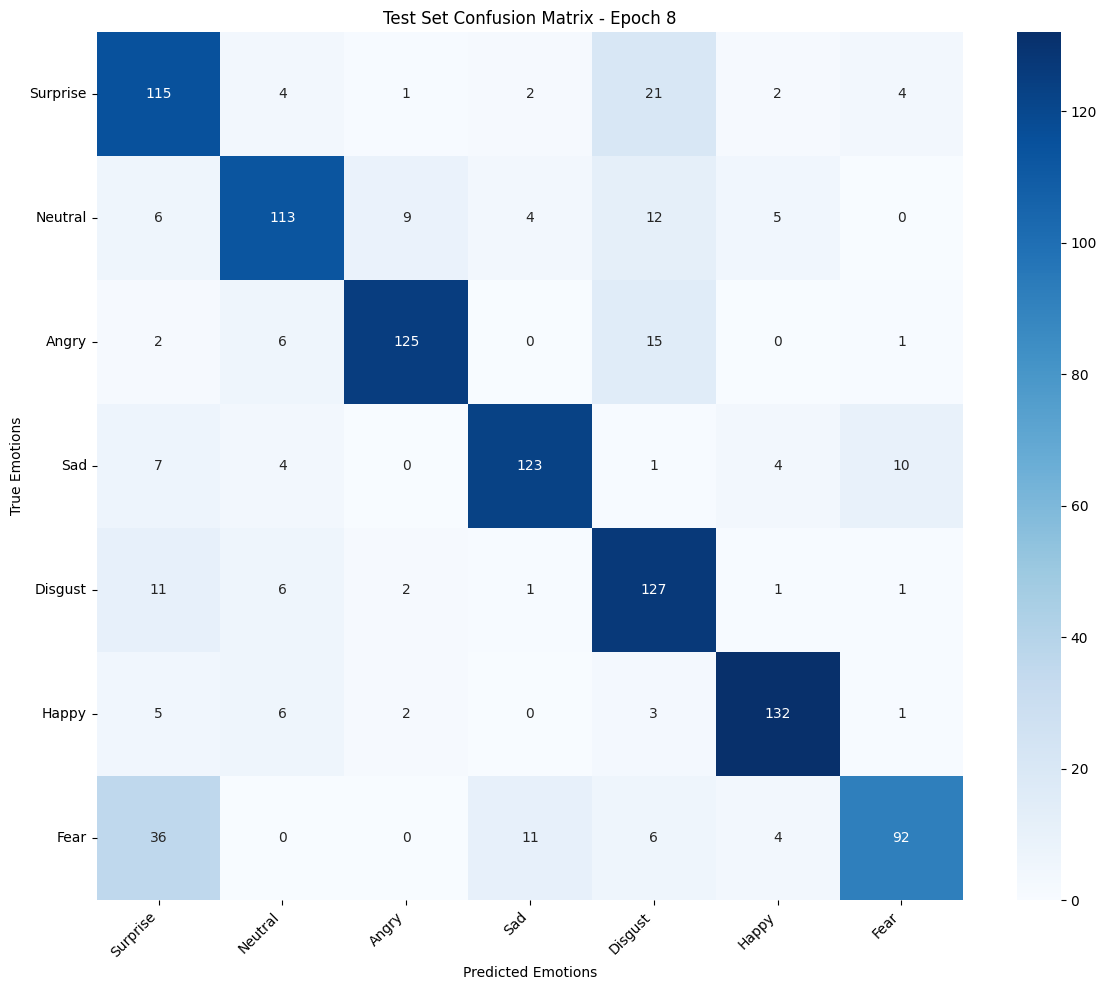

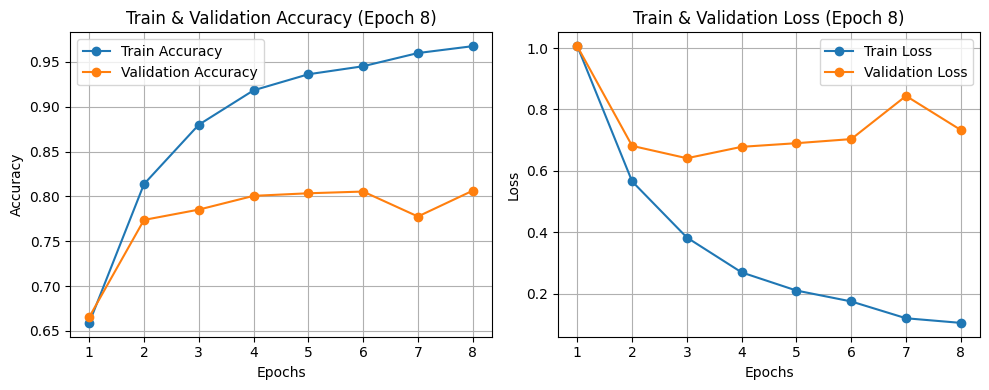


--- End of Epoch 8 ---



Val Epoch 9/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [9/20]
Train Loss: 0.1019 | Train Acc: 0.9677
Val Loss: 0.8424 | Val Acc: 0.7910

Running evaluation on Test Set...


Test Epoch 9/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 9
              precision    recall  f1-score   support

    Surprise     0.9120    0.7651    0.8321       149
     Neutral     0.6821    0.8926    0.7733       149
       Angry     0.9223    0.6376    0.7540       149
         Sad     0.8227    0.7785    0.8000       149
     Disgust     0.6685    0.7987    0.7278       149
       Happy     0.8759    0.8054    0.8392       149
        Fear     0.7073    0.7785    0.7412       149

    accuracy                         0.7795      1043
   macro avg     0.7987    0.7795    0.7811      1043
weighted avg     0.7987    0.7795    0.7811      1043



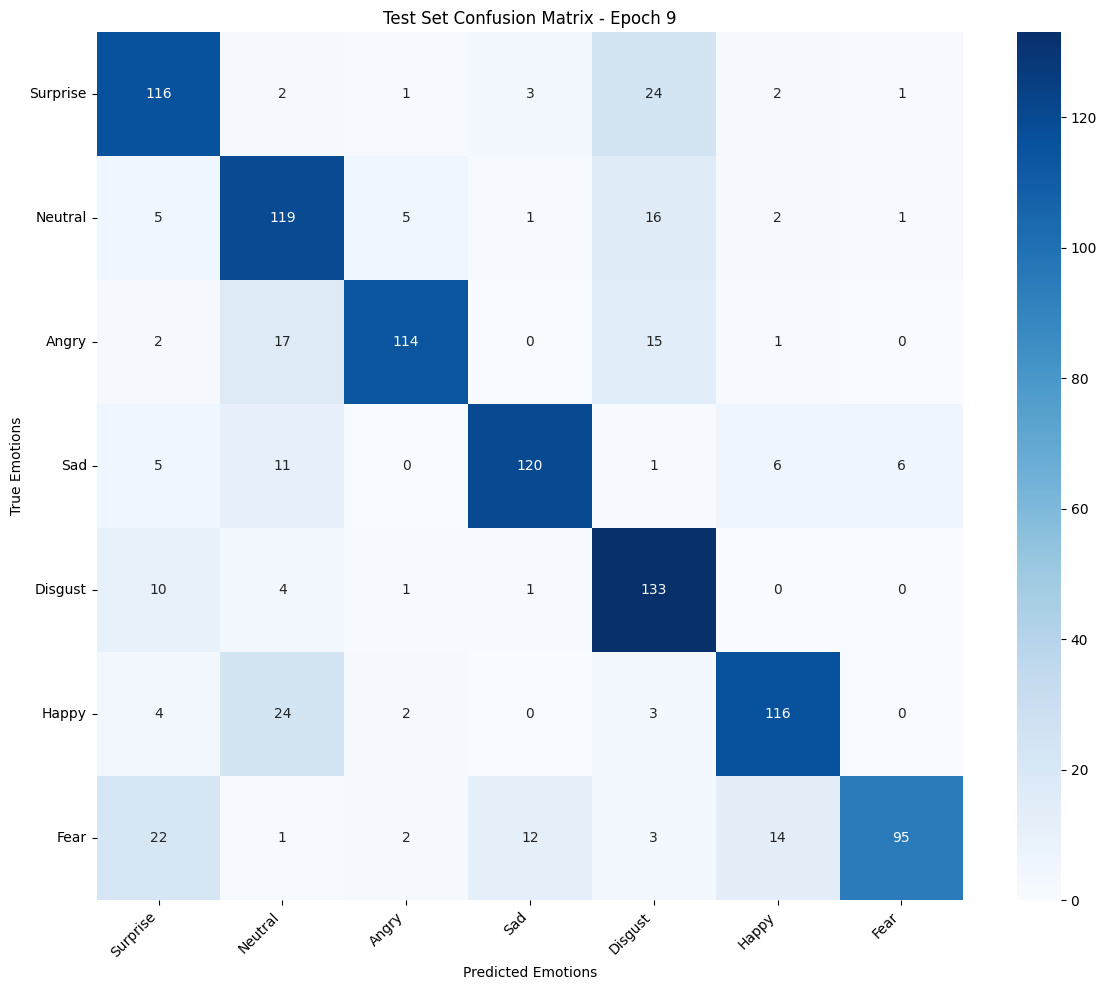

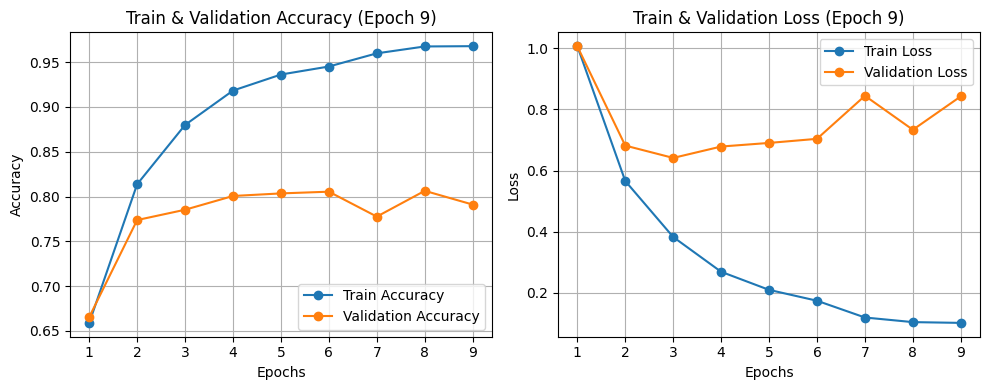


--- End of Epoch 9 ---



Val Epoch 10/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [10/20]
Train Loss: 0.0848 | Train Acc: 0.9760
Val Loss: 0.8313 | Val Acc: 0.7891

Running evaluation on Test Set...


Test Epoch 10/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 10
              precision    recall  f1-score   support

    Surprise     0.8968    0.7584    0.8218       149
     Neutral     0.6667    0.8188    0.7349       149
       Angry     0.9038    0.6309    0.7431       149
         Sad     0.8630    0.8456    0.8542       149
     Disgust     0.6685    0.8121    0.7333       149
       Happy     0.9008    0.7919    0.8429       149
        Fear     0.6744    0.7785    0.7227       149

    accuracy                         0.7766      1043
   macro avg     0.7963    0.7766    0.7790      1043
weighted avg     0.7963    0.7766    0.7790      1043



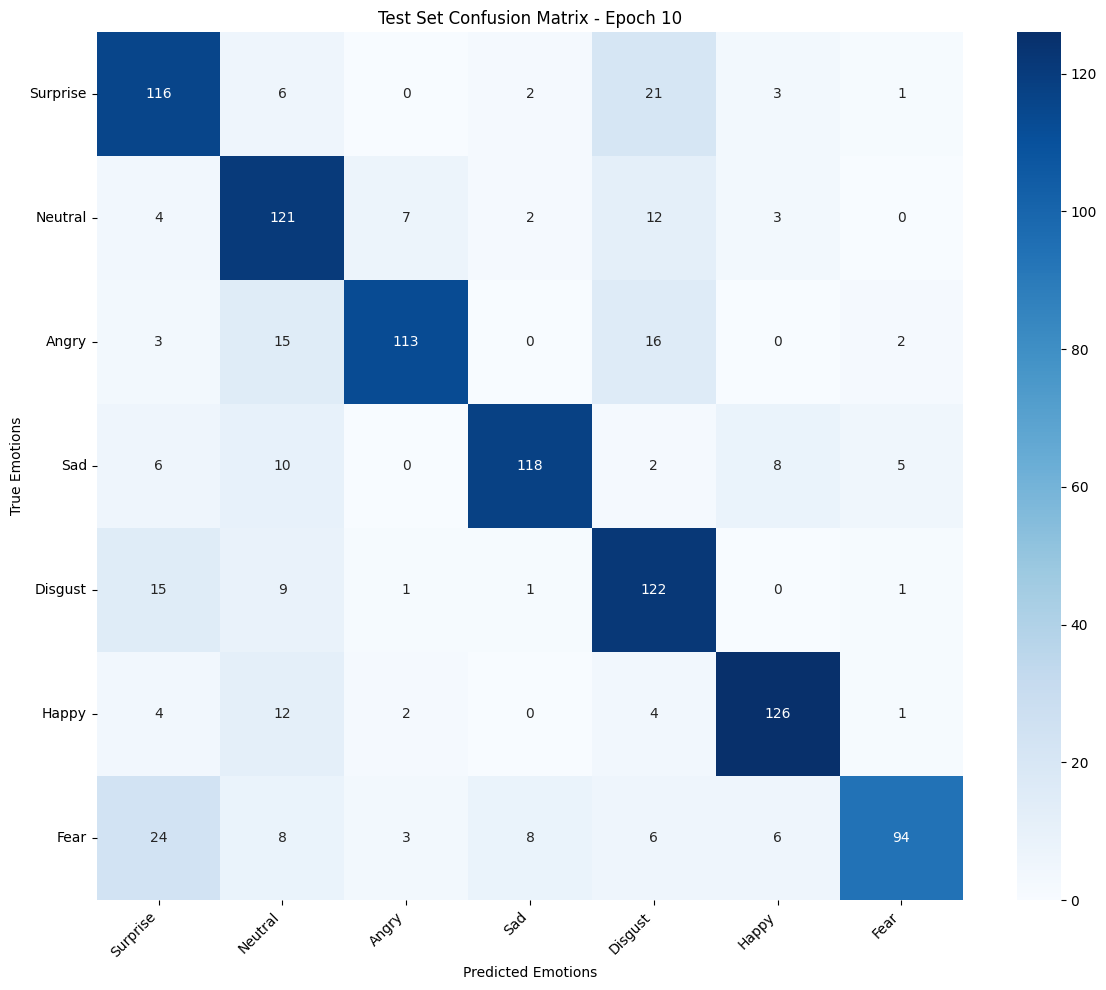

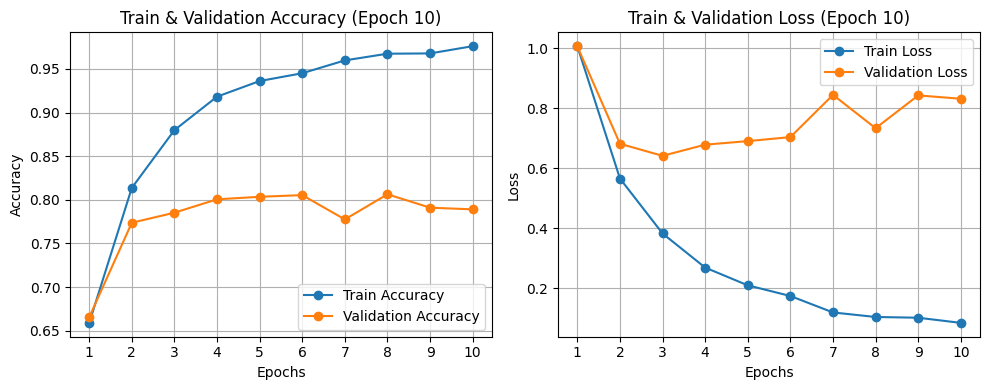


--- End of Epoch 10 ---



Val Epoch 11/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [11/20]
Train Loss: 0.0768 | Train Acc: 0.9748
Val Loss: 0.8072 | Val Acc: 0.8015

Running evaluation on Test Set...


Test Epoch 11/20: 100%|██████████| 261/261 [01:49<00:00,  2.38it/s]



Test Set Classification Report - Epoch 11
              precision    recall  f1-score   support

    Surprise     0.8750    0.7517    0.8087       149
     Neutral     0.8218    0.5570    0.6640       149
       Angry     0.8370    0.7584    0.7958       149
         Sad     0.9167    0.8859    0.9010       149
     Disgust     0.7305    0.8188    0.7722       149
       Happy     0.8792    0.8792    0.8792       149
        Fear     0.5982    0.8792    0.7120       149

    accuracy                         0.7900      1043
   macro avg     0.8083    0.7900    0.7904      1043
weighted avg     0.8083    0.7900    0.7904      1043



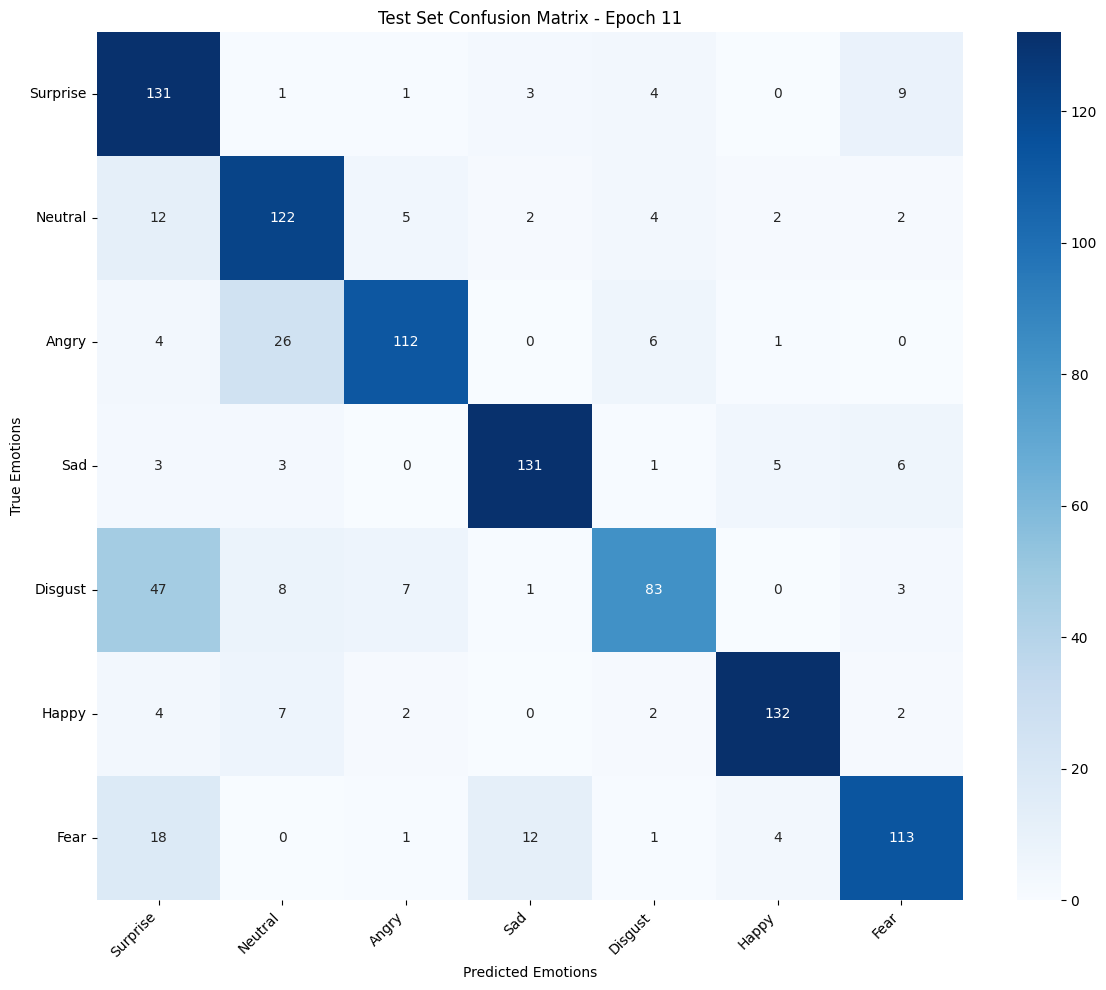

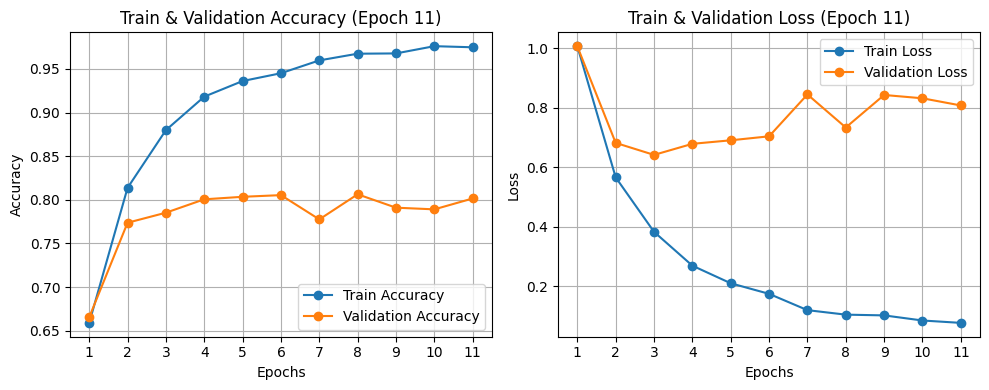


--- End of Epoch 11 ---



Val Epoch 12/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [12/20]
Train Loss: 0.0719 | Train Acc: 0.9770
Val Loss: 0.8936 | Val Acc: 0.7910

Running evaluation on Test Set...


Test Epoch 12/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 12
              precision    recall  f1-score   support

    Surprise     0.7919    0.7919    0.7919       149
     Neutral     0.8361    0.6846    0.7528       149
       Angry     0.8615    0.7517    0.8029       149
         Sad     0.9185    0.8322    0.8732       149
     Disgust     0.6592    0.7919    0.7195       149
       Happy     0.9167    0.7383    0.8178       149
        Fear     0.6250    0.8725    0.7283       149

    accuracy                         0.7804      1043
   macro avg     0.8013    0.7804    0.7838      1043
weighted avg     0.8013    0.7804    0.7838      1043



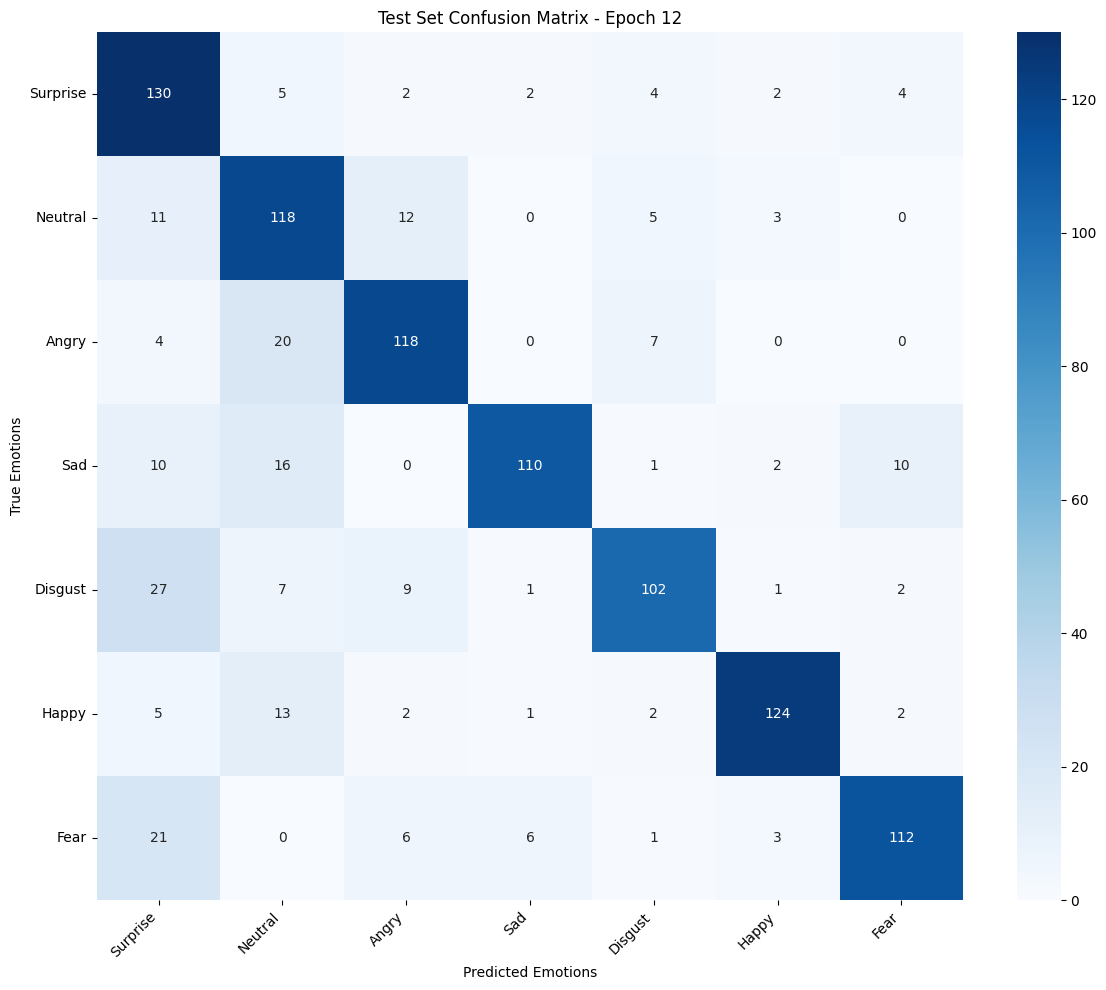

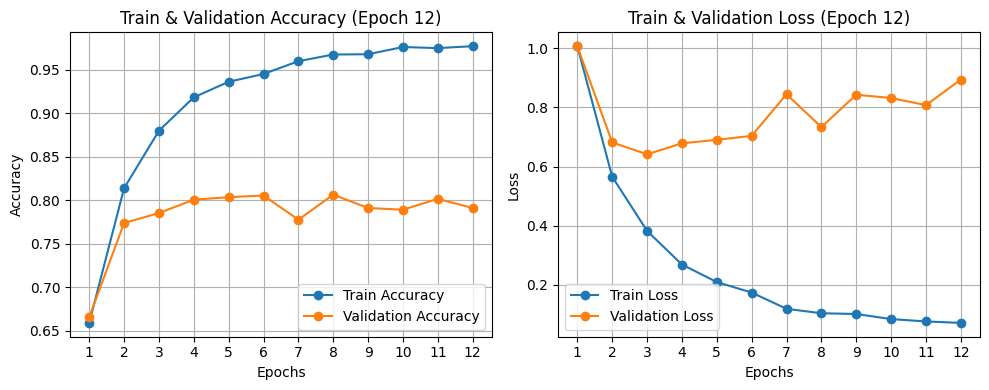


--- End of Epoch 12 ---



Val Epoch 13/20: 100%|██████████| 261/261 [01:48<00:00,  2.40it/s]



Epoch [13/20]
Train Loss: 0.0743 | Train Acc: 0.9764
Val Loss: 0.9427 | Val Acc: 0.7872

Running evaluation on Test Set...


Test Epoch 13/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 13
              precision    recall  f1-score   support

    Surprise     0.8714    0.8188    0.8443       149
     Neutral     0.6615    0.8658    0.7500       149
       Angry     0.8060    0.7248    0.7633       149
         Sad     0.8873    0.8456    0.8660       149
     Disgust     0.7222    0.7852    0.7524       149
       Happy     0.9417    0.6510    0.7698       149
        Fear     0.7246    0.8121    0.7658       149

    accuracy                         0.7862      1043
   macro avg     0.8021    0.7862    0.7874      1043
weighted avg     0.8021    0.7862    0.7874      1043



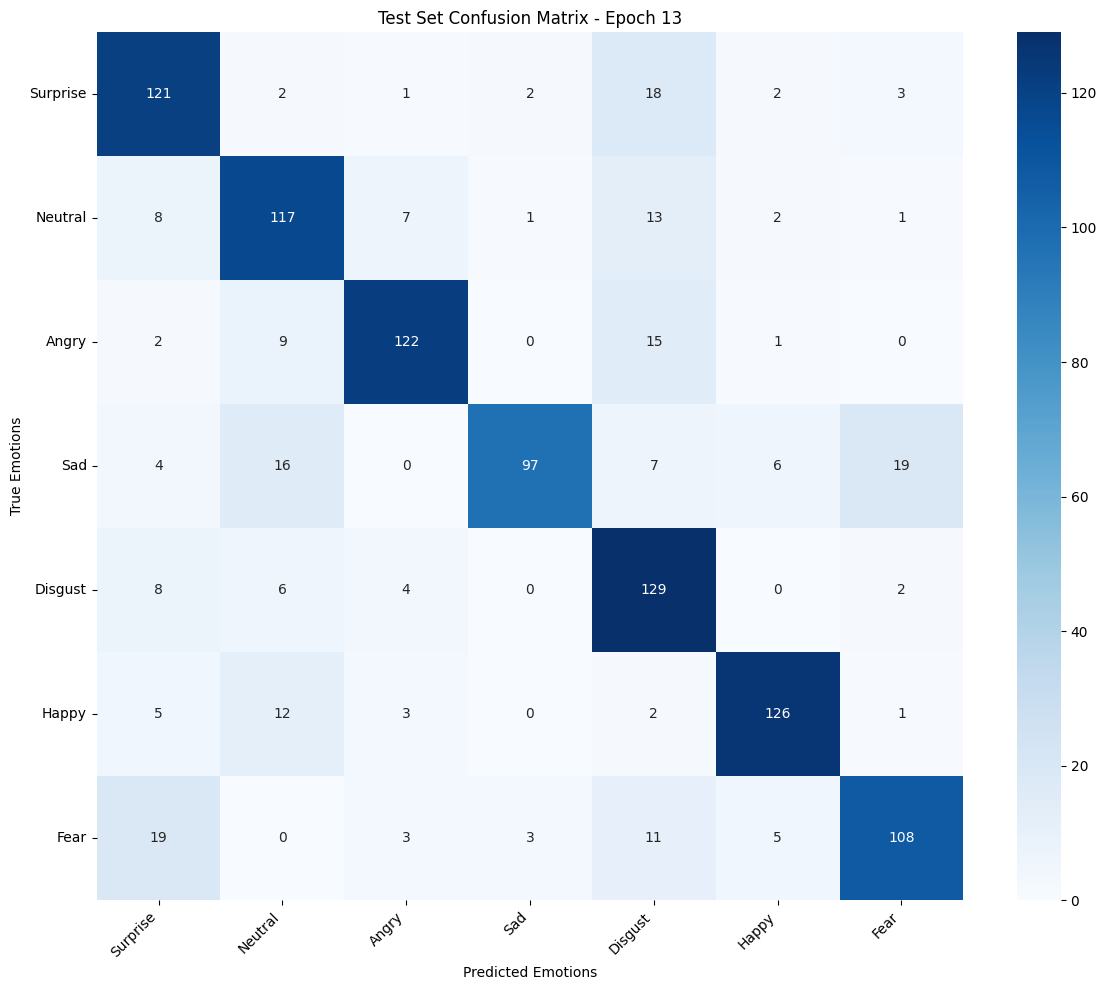

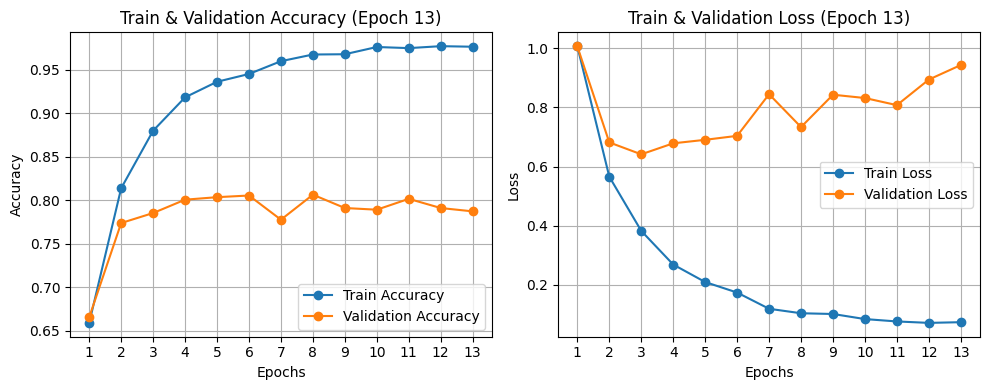


--- End of Epoch 13 ---



Val Epoch 14/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [14/20]
Train Loss: 0.0469 | Train Acc: 0.9863
Val Loss: 0.8516 | Val Acc: 0.8130

Running evaluation on Test Set...


Test Epoch 14/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 14
              precision    recall  f1-score   support

    Surprise     0.8456    0.8456    0.8456       149
     Neutral     0.7597    0.7852    0.7723       149
       Angry     0.8898    0.7047    0.7865       149
         Sad     0.9474    0.8456    0.8936       149
     Disgust     0.7823    0.7718    0.7770       149
       Happy     0.7953    0.9128    0.8500       149
        Fear     0.6784    0.7785    0.7250       149

    accuracy                         0.8063      1043
   macro avg     0.8141    0.8063    0.8072      1043
weighted avg     0.8141    0.8063    0.8072      1043



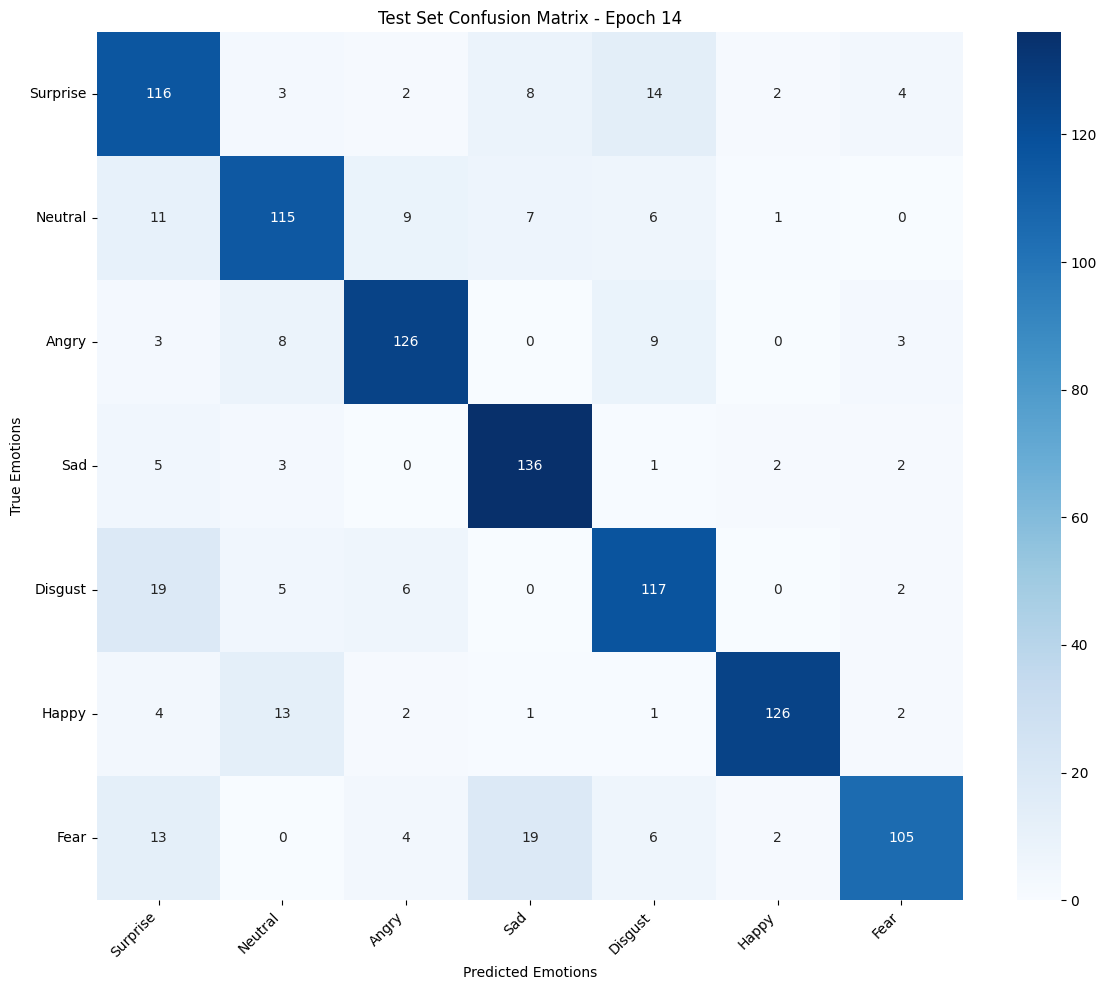

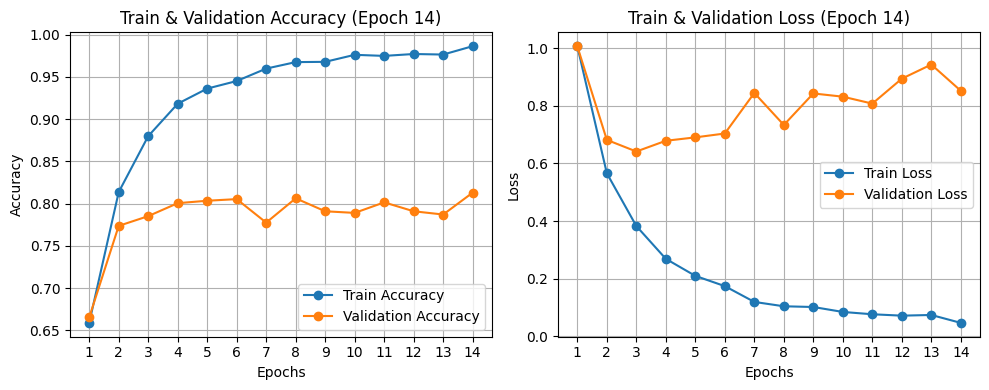


--- End of Epoch 14 ---



Val Epoch 15/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [15/20]
Train Loss: 0.0462 | Train Acc: 0.9869
Val Loss: 1.1535 | Val Acc: 0.7651

Running evaluation on Test Set...


Test Epoch 15/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 15
              precision    recall  f1-score   support

    Surprise     0.9055    0.7718    0.8333       149
     Neutral     0.6329    0.8792    0.7360       149
       Angry     0.9487    0.4966    0.6520       149
         Sad     0.9520    0.7987    0.8686       149
     Disgust     0.7687    0.7584    0.7635       149
       Happy     0.8269    0.8658    0.8459       149
        Fear     0.6158    0.8389    0.7102       149

    accuracy                         0.7728      1043
   macro avg     0.8072    0.7728    0.7728      1043
weighted avg     0.8072    0.7728    0.7728      1043



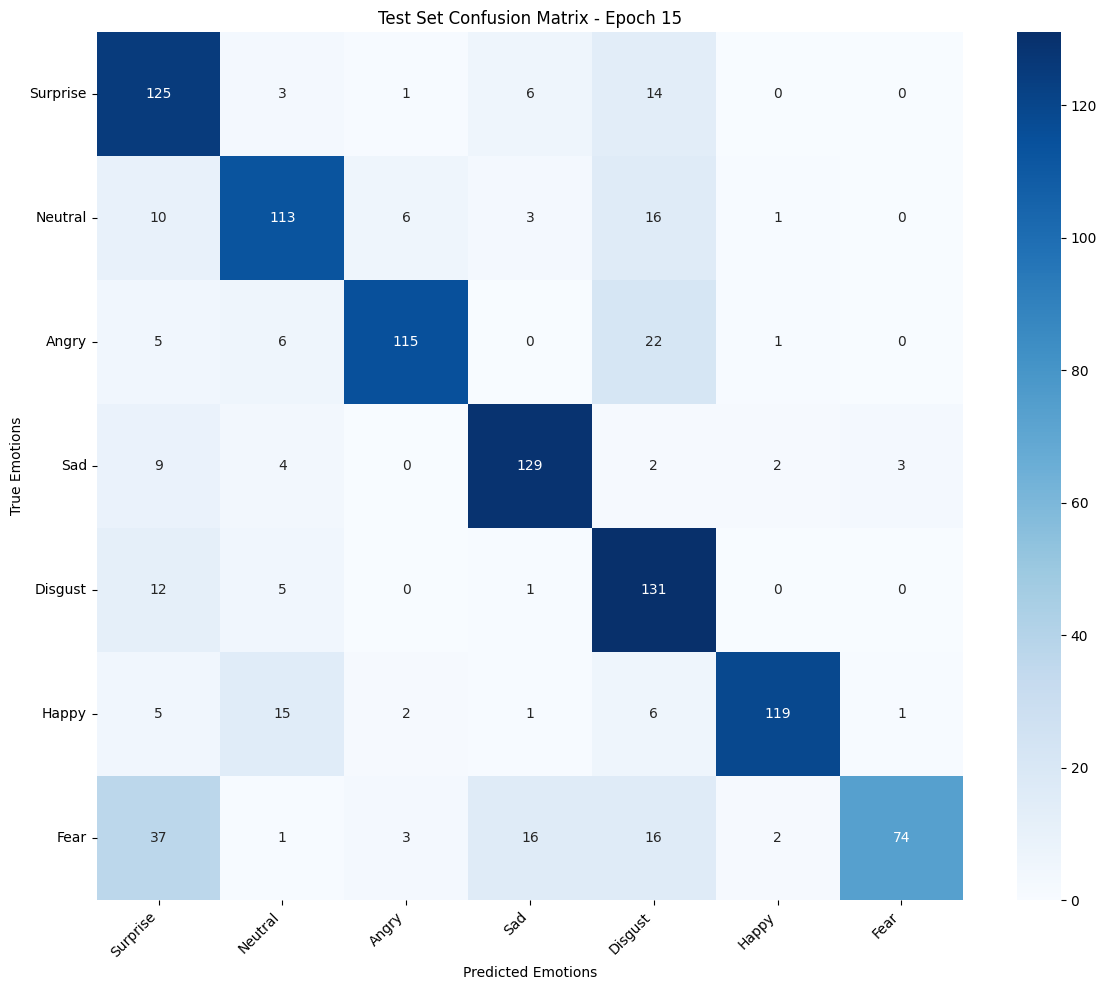

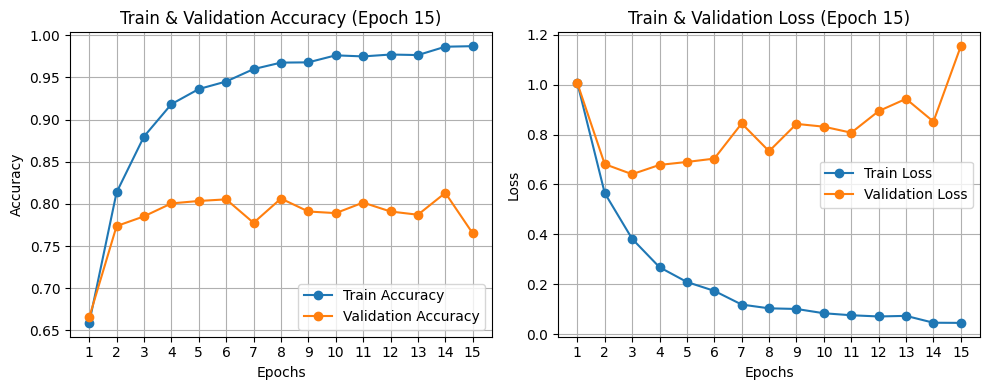


--- End of Epoch 15 ---



Val Epoch 16/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [16/20]
Train Loss: 0.0645 | Train Acc: 0.9789
Val Loss: 0.9677 | Val Acc: 0.8054

Running evaluation on Test Set...


Test Epoch 16/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 16
              precision    recall  f1-score   support

    Surprise     0.8280    0.8725    0.8497       149
     Neutral     0.7717    0.6577    0.7101       149
       Angry     0.8846    0.7718    0.8244       149
         Sad     0.9820    0.7315    0.8385       149
     Disgust     0.6746    0.7651    0.7170       149
       Happy     0.8531    0.8188    0.8356       149
        Fear     0.6359    0.8792    0.7380       149

    accuracy                         0.7852      1043
   macro avg     0.8043    0.7852    0.7876      1043
weighted avg     0.8043    0.7852    0.7876      1043



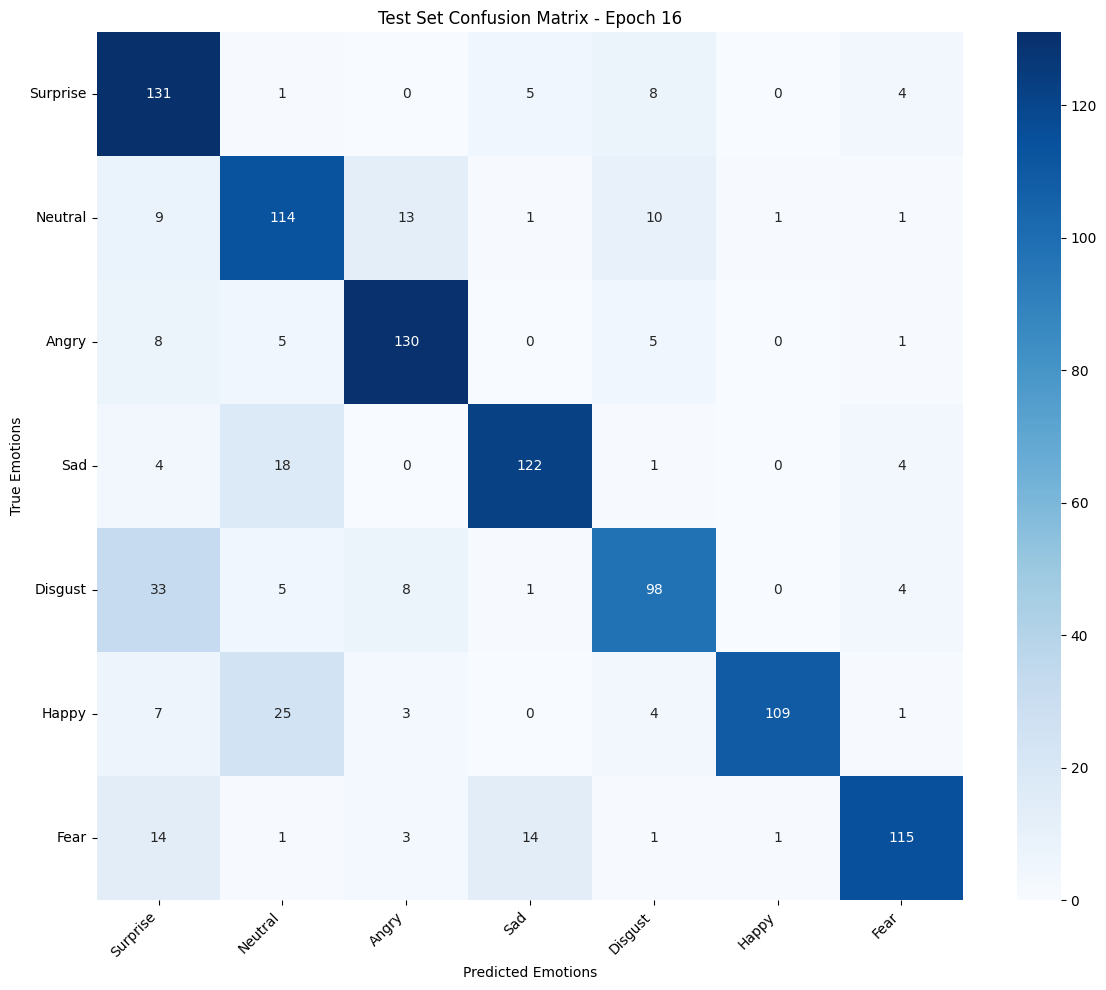

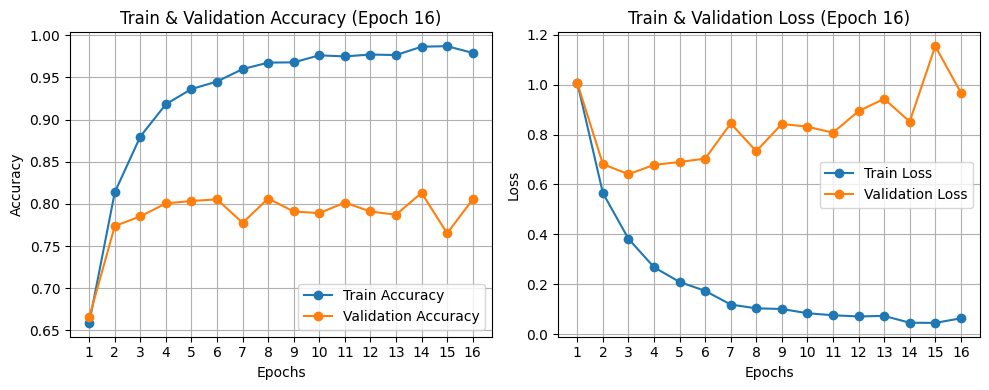


--- End of Epoch 16 ---



Val Epoch 17/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [17/20]
Train Loss: 0.0551 | Train Acc: 0.9840
Val Loss: 0.9035 | Val Acc: 0.8063

Running evaluation on Test Set...


Test Epoch 17/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 17
              precision    recall  f1-score   support

    Surprise     0.8267    0.8322    0.8294       149
     Neutral     0.7923    0.6913    0.7384       149
       Angry     0.8333    0.7047    0.7636       149
         Sad     0.9603    0.8121    0.8800       149
     Disgust     0.6949    0.8255    0.7546       149
       Happy     0.9000    0.8456    0.8720       149
        Fear     0.6495    0.8456    0.7347       149

    accuracy                         0.7939      1043
   macro avg     0.8081    0.7939    0.7961      1043
weighted avg     0.8081    0.7939    0.7961      1043



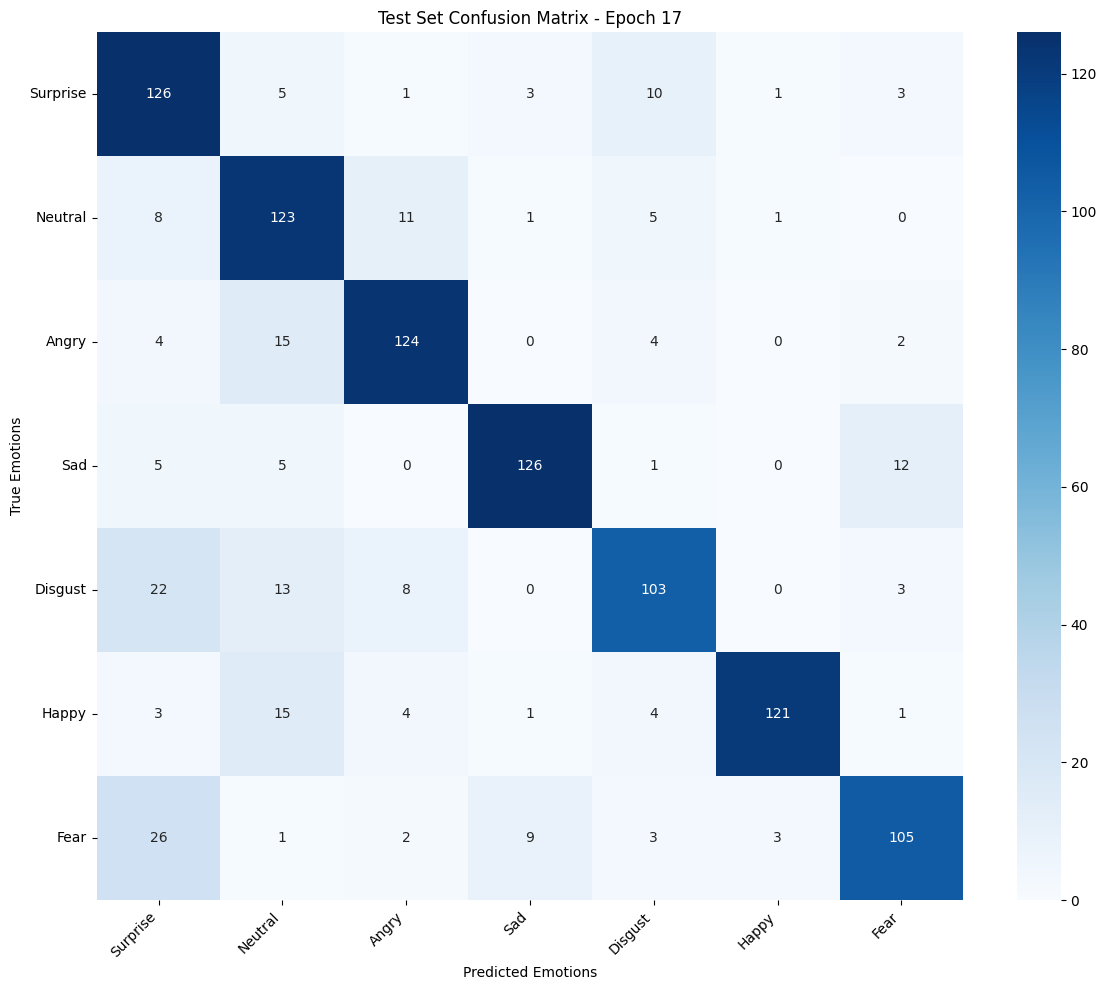

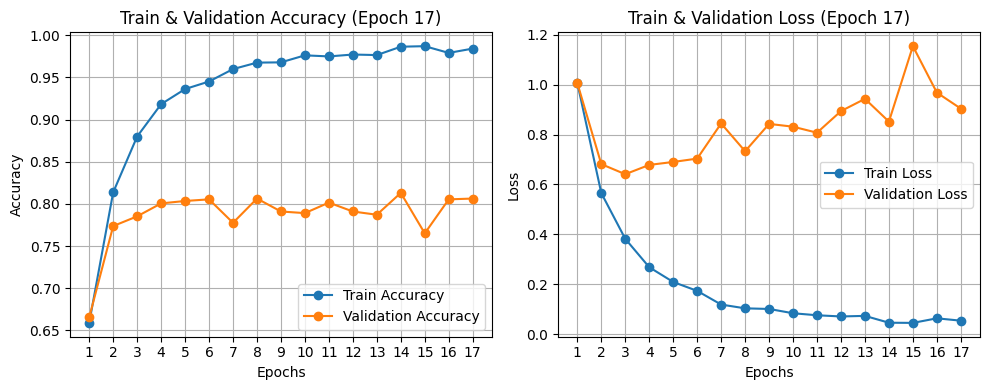


--- End of Epoch 17 ---



Val Epoch 18/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [18/20]
Train Loss: 0.0587 | Train Acc: 0.9802
Val Loss: 1.0694 | Val Acc: 0.7728

Running evaluation on Test Set...


Test Epoch 18/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 18
              precision    recall  f1-score   support

    Surprise     0.8760    0.7584    0.8129       149
     Neutral     0.8571    0.4832    0.6180       149
       Angry     0.9200    0.6174    0.7390       149
         Sad     0.9259    0.8389    0.8803       149
     Disgust     0.6545    0.8389    0.7353       149
       Happy     0.8992    0.7785    0.8345       149
        Fear     0.5091    0.9396    0.6604       149

    accuracy                         0.7507      1043
   macro avg     0.8060    0.7507    0.7543      1043
weighted avg     0.8060    0.7507    0.7543      1043



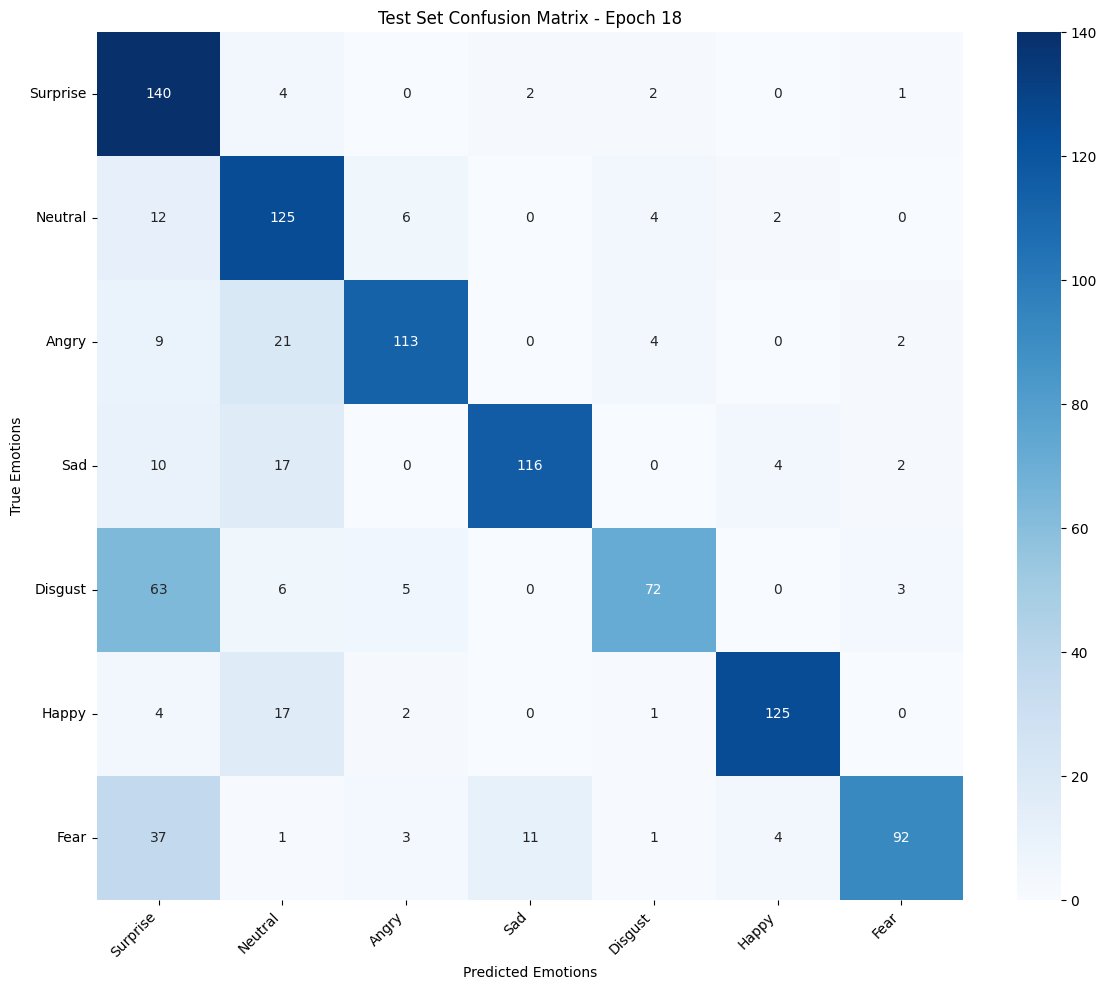

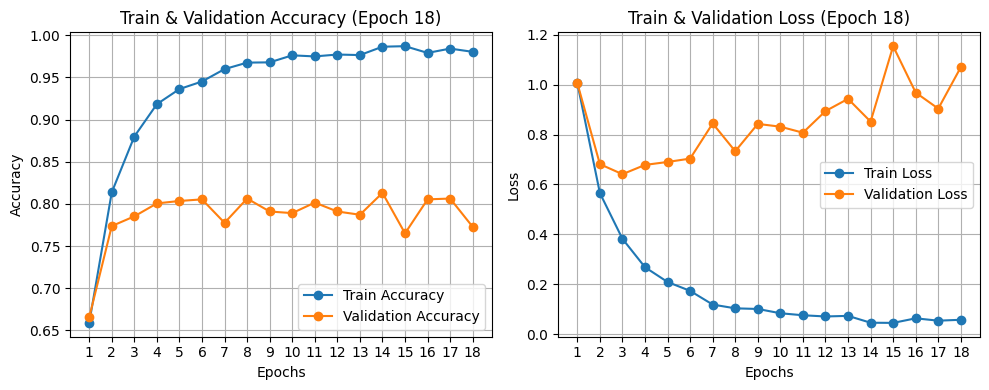


--- End of Epoch 18 ---



Val Epoch 19/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [19/20]
Train Loss: 0.0448 | Train Acc: 0.9847
Val Loss: 0.8234 | Val Acc: 0.8207

Running evaluation on Test Set...


Test Epoch 19/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 19
              precision    recall  f1-score   support

    Surprise     0.8301    0.8523    0.8411       149
     Neutral     0.7500    0.7651    0.7575       149
       Angry     0.8583    0.6913    0.7658       149
         Sad     0.9000    0.9060    0.9030       149
     Disgust     0.7301    0.7987    0.7628       149
       Happy     0.8905    0.8188    0.8531       149
        Fear     0.6964    0.7852    0.7382       149

    accuracy                         0.8025      1043
   macro avg     0.8079    0.8025    0.8031      1043
weighted avg     0.8079    0.8025    0.8031      1043



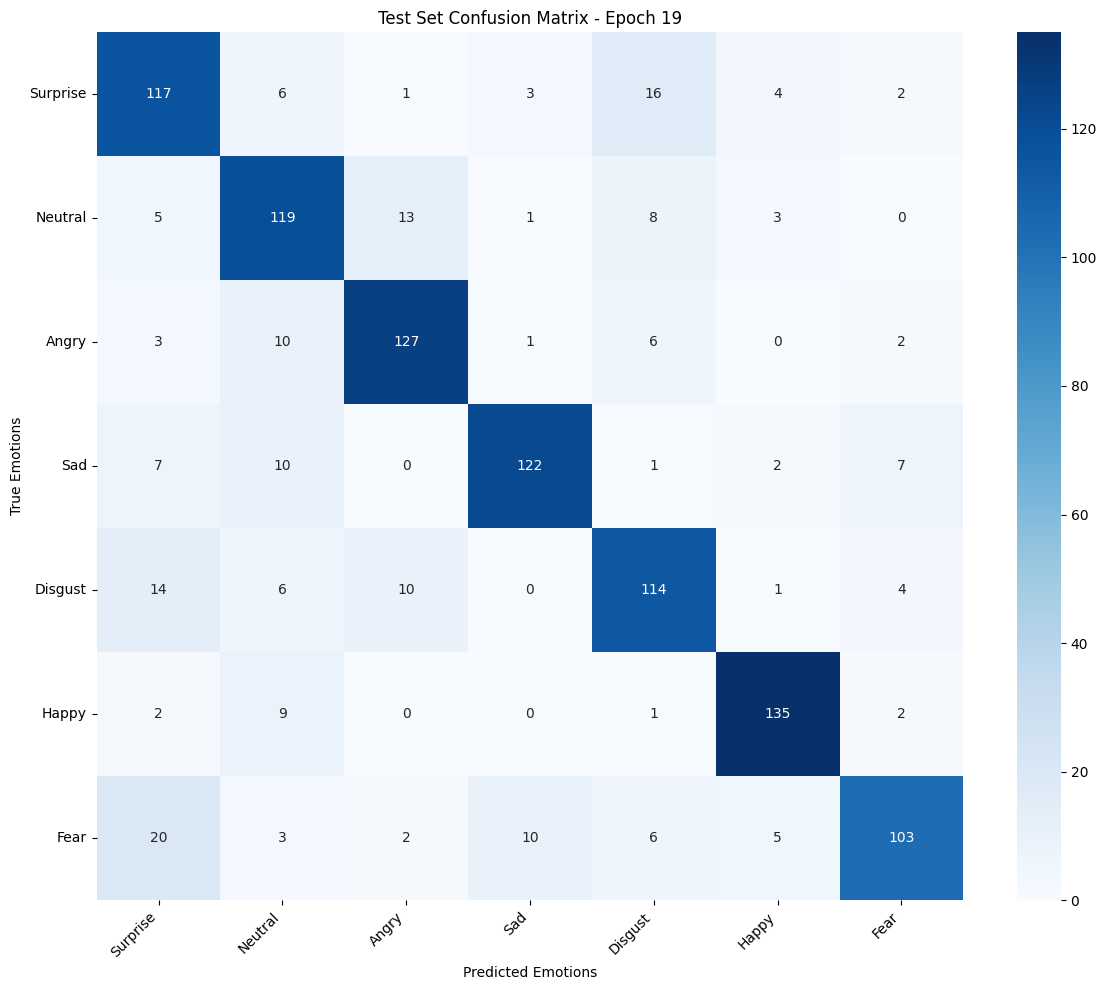

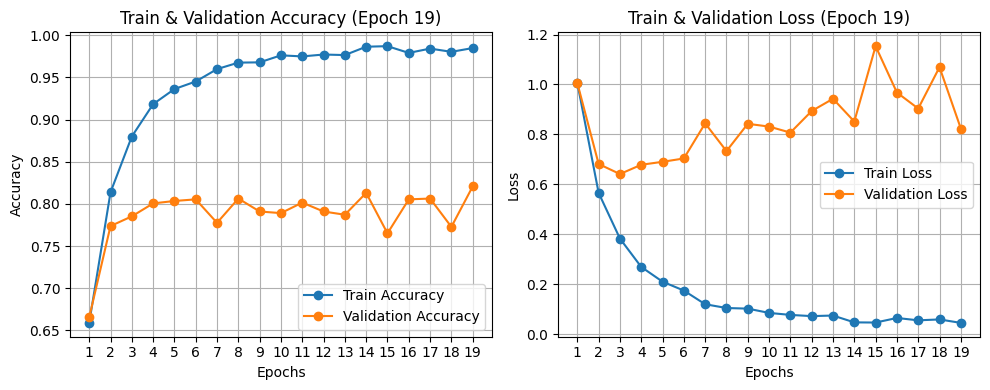


--- End of Epoch 19 ---



Val Epoch 20/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Epoch [20/20]
Train Loss: 0.0616 | Train Acc: 0.9815
Val Loss: 0.9883 | Val Acc: 0.7843

Running evaluation on Test Set...


Test Epoch 20/20: 100%|██████████| 261/261 [01:49<00:00,  2.39it/s]



Test Set Classification Report - Epoch 20
              precision    recall  f1-score   support

    Surprise     0.8913    0.8255    0.8571       149
     Neutral     0.5833    0.9396    0.7198       149
       Angry     0.9639    0.5369    0.6897       149
         Sad     0.9280    0.7785    0.8467       149
     Disgust     0.6946    0.7785    0.7342       149
       Happy     0.8101    0.8591    0.8339       149
        Fear     0.7424    0.6577    0.6975       149

    accuracy                         0.7680      1043
   macro avg     0.8020    0.7680    0.7684      1043
weighted avg     0.8020    0.7680    0.7684      1043



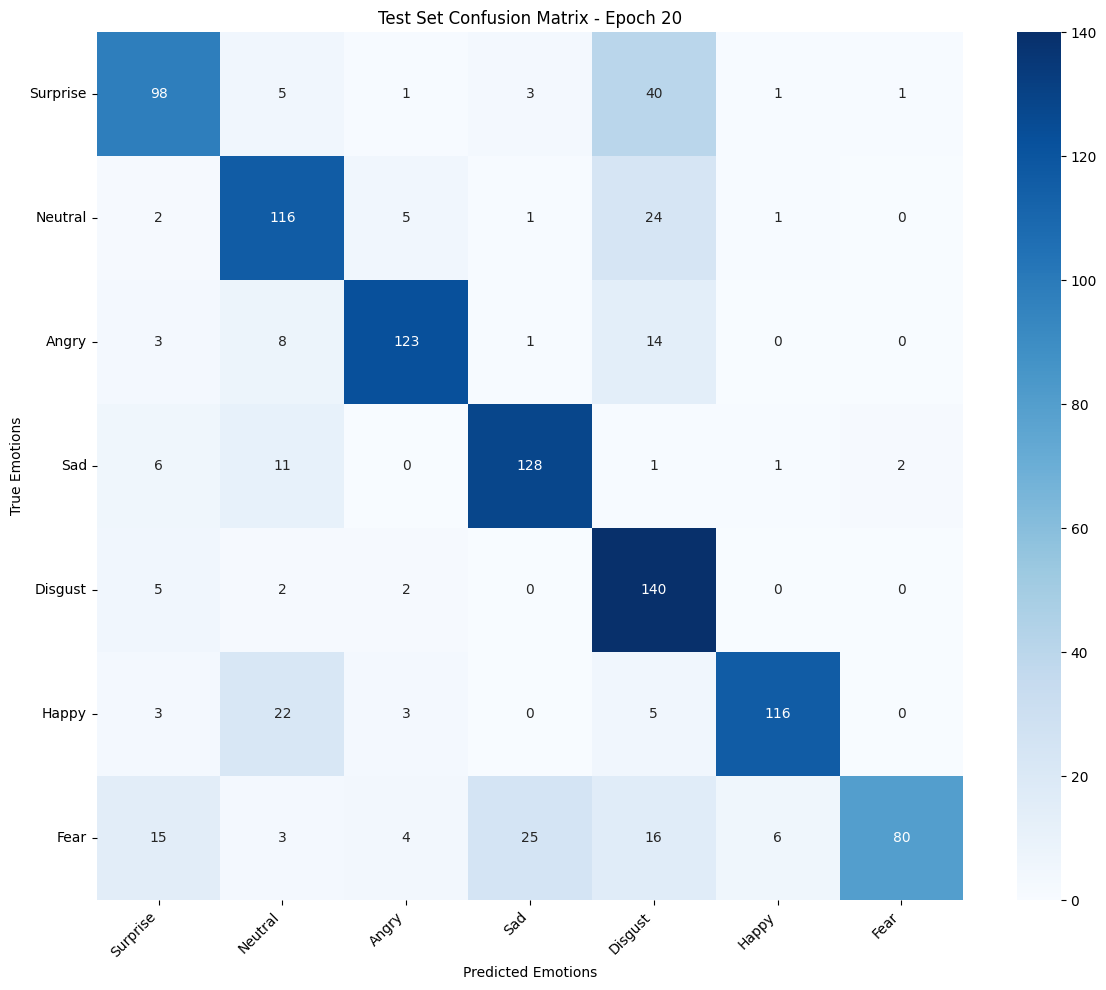

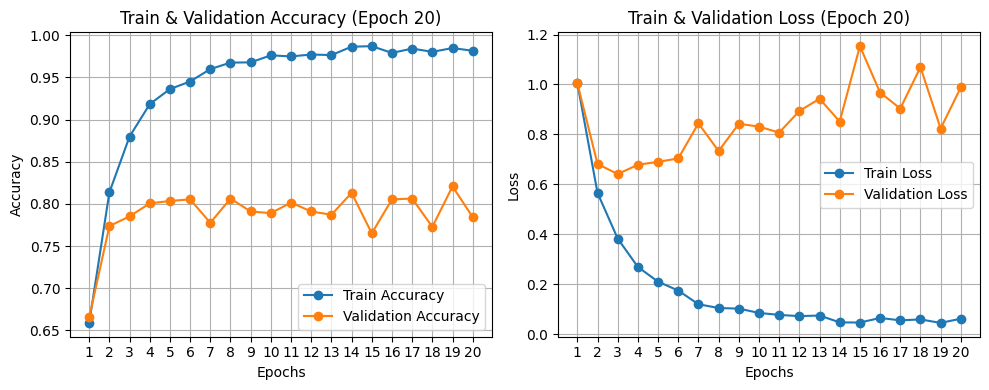


--- End of Epoch 20 ---



In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    train_progress = tqdm(train_dataloader, desc=f"Train Epoch {epoch + 1}/{num_epochs}")
    
    for batch_idx, (inputs, targets) in enumerate(train_progress):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_correct += (outputs.argmax(1) == targets).sum().item()
        total_train_samples += targets.size(0)

        current_loss = total_train_loss / (batch_idx + 1)
        current_acc = total_train_correct / total_train_samples
        train_progress.set_postfix(loss=current_loss, accuracy=current_acc)

    epoch_train_loss = total_train_loss / len(train_dataloader)
    epoch_train_acc = total_train_correct / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        val_progress = tqdm(val_dataloader, desc=f"Val Epoch {epoch + 1}/{num_epochs}")
        
        for inputs, targets in val_progress:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs).logits
            loss = criterion(outputs, targets)

            total_val_loss += loss.item()
            total_val_correct += (outputs.argmax(1) == targets).sum().item()
            total_val_samples += targets.size(0)

    epoch_val_loss = total_val_loss / len(val_dataloader)
    epoch_val_acc = total_val_correct / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'\nEpoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    print("\nRunning evaluation on Test Set...")
    all_preds = []
    all_targets = []
    
    model.eval()
    with torch.no_grad():
        test_progress = tqdm(test_dataloader, desc=f"Test Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in test_progress:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    y_true_labels = [emotion_mapping[label] for label in all_targets]
    y_pred_labels = [emotion_mapping[label] for label in all_preds]

    print("\n" + "="*50)
    print(f"Test Set Classification Report - Epoch {epoch + 1}")
    print("="*50)
    print(classification_report(
        y_true_labels, 
        y_pred_labels, 
        target_names=target_names,
        digits=4,
        zero_division=0
    ))

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=target_names)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted Emotions')
    plt.ylabel('True Emotions')
    plt.title(f'Test Set Confusion Matrix - Epoch {epoch + 1}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_epoch_{epoch + 1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train & Validation Accuracy (Epoch {epoch + 1})')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, epoch + 2))


    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train & Validation Loss (Epoch {epoch + 1})')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, epoch + 2))

    plt.tight_layout()
    plt.savefig(f'accuracy_loss_graphs_epoch_{epoch + 1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f'\n--- End of Epoch {epoch + 1} ---\n')